<a href="https://colab.research.google.com/github/DEP04929/ESICMDatathon2024/blob/main/AKI_20240618_7x24_KMeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pre-requisites for Amsterdam UMC DB


In [1]:
# sets *your* project id
PROJECT_ID = "esicmdatathon2024" #@param {type:"string"}


In [2]:
# sets default dataset for AmsterdamUMCdb
DATASET_PROJECT_ID = 'amsterdamumcdb' #@param {type:"string"}
DATASET_ID = 'version1_5_0' #@param {type:"string"}
LOCATION = 'eu' #@param {type:"string"}

In [3]:
import os
from google.colab import auth

# all libraries check this environment variable, so set it:
os.environ["GOOGLE_CLOUD_PROJECT"] = PROJECT_ID

auth.authenticate_user()
print('Authenticated')


Authenticated


In [4]:
%load_ext google.colab.data_table
from google.colab.data_table import DataTable

# change default limits:
DataTable.max_columns = 200
DataTable.max_rows = 30000


In [5]:
from google.cloud.bigquery import magics
from google.cloud import bigquery

# sets the default query job configuration
def_config = bigquery.job.QueryJobConfig(default_dataset=DATASET_PROJECT_ID + "." + DATASET_ID)
magics.context.default_query_job_config = def_config


In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [7]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)
pd.set_option('display.expand_frame_repr', True)

In [8]:

config_gbq = {'query':
          {'defaultDataset': {
              "datasetId": DATASET_ID,
              "projectId": DATASET_PROJECT_ID
              },
           'Location': LOCATION}
           }

# Get list of patients for AKI

## Part 1/2 get AKI patients




In [9]:
%%bigquery AKI --project $PROJECT_ID
-- only take visits that are longer than 2 days
WITH included_patients AS (
  SELECT person_id, visit_occurrence_id
  FROM visit_occurrence
  WHERE DATE_DIFF(visit_end_datetime, visit_start_datetime, hour)/24.0 >= 2
),
-- count measurements of creatinine > 1
patients_with_creatinine AS (
  SELECT person_id, visit_occurrence_id
  FROM measurement
  WHERE measurement_concept_id = 3020564 -- Creatinine
    AND provider_id IS NOT NULL
    AND visit_occurrence_id IN (
        SELECT visit_occurrence_id FROM included_patients
    )
  GROUP BY person_id, visit_occurrence_id
  HAVING COUNT(measurement_id) > 1
),
-- creatinine value > 400 before visit
excluded_high_creatinine AS (
  SELECT DISTINCT visit_occurrence_id
  FROM measurement
  WHERE measurement_concept_id = 3020564 -- Creatinine
    AND provider_id IS NOT NULL
    AND measurement_datetime < (SELECT visit_start_datetime
                            FROM visit_occurrence
                            WHERE visit_occurrence_id = measurement.visit_occurrence_id)
    AND value_as_number > 400
),
-- Exclude kidney transplant persons regardless of timestamp of procedure
excluded_nephrectomy_kidney_transplant AS (
  SELECT DISTINCT visit_occurrence_id
  FROM procedure_occurrence
  WHERE procedure_concept_id IN (4146256, 4021108, 4022014, 4322471) -- Nephrectomy and Kidney Transplant
  AND provider_id IS NOT NULL
),
-- Exclude rrt before first admission by visit
excluded_rrt_before_admission AS (
  SELECT DISTINCT p.visit_occurrence_id
  FROM procedure_occurrence p
  inner join visit_occurrence v
  on v.visit_occurrence_id = p.visit_occurrence_id
  WHERE p.procedure_concept_id = 4051330 -- RRT
    AND p.provider_id IS NOT NULL
    AND p.procedure_datetime < visit_start_datetime
),
-- exclude too little count of creatinine before the first RRT by person not by visit
excluded_few_creatinine_before_rrt AS (
  SELECT visit_occurrence_id
  FROM (
      SELECT visit_occurrence_id, COUNT(measurement_id) AS creatinine_measurement_count
      FROM measurement m
      WHERE measurement_concept_id = 3020564 --Creatinine
        AND provider_id IS NOT NULL
        AND measurement_datetime < (SELECT MIN(procedure_datetime)
                                FROM procedure_occurrence p
                                WHERE procedure_concept_id = 4051330 -- RRT
                                  AND provider_id IS NOT NULL
                                  AND p.visit_occurrence_id = m.visit_occurrence_id)
      GROUP BY m.visit_occurrence_id
  ) AS subquery
  WHERE creatinine_measurement_count <= 1
),

-- this gives the set of included persons
final_patients AS (
  SELECT person_id, visit_occurrence_id
  FROM patients_with_creatinine
  WHERE visit_occurrence_id NOT IN (SELECT visit_occurrence_id FROM excluded_high_creatinine)
    AND visit_occurrence_id NOT IN (SELECT visit_occurrence_id FROM excluded_nephrectomy_kidney_transplant)
    AND visit_occurrence_id NOT IN (SELECT visit_occurrence_id FROM excluded_rrt_before_admission)
    AND visit_occurrence_id NOT IN (SELECT visit_occurrence_id FROM excluded_few_creatinine_before_rrt)
),

first_scr AS (
  SELECT
    m.person_id
    , m.visit_occurrence_id
    , m.value_as_number AS first_scr
  FROM
    measurement m
  JOIN
    visit_occurrence v ON m.visit_occurrence_id = v.visit_occurrence_id
  WHERE
    m.measurement_concept_id = 3020564 -- Creatinine
    AND m.provider_id IS NOT NULL
    AND m.measurement_datetime BETWEEN timestamp_add(v.visit_start_datetime, INTERVAL -365 day)
                               AND timestamp_add(v.visit_start_datetime, INTERVAL 7 day)
    AND m.visit_occurrence_id IN (SELECT visit_occurrence_id FROM final_patients)
  QUALIFY
    ROW_NUMBER() OVER (PARTITION BY m.person_id, m.visit_occurrence_id
          -- this is to find the baseline scr nearest to the visit start datetime :
           ORDER BY abs(timestamp_diff(m.measurement_datetime, visit_start_datetime, minute)) asc ) = 1
),
-- need highest creatinine during stay for determining AKI later steps
aki_patients AS (
  SELECT m.visit_occurrence_id,
    max(m.value_as_number) AS highest_scr,
  FROM measurement m
  inner JOIN
    first_scr l ON m.visit_occurrence_id = l.visit_occurrence_id
  inner join visit_occurrence v
    on m.visit_occurrence_id = v.visit_occurrence_id
  WHERE
    m.measurement_concept_id = 3020564 -- creatinine
    AND m.provider_id IS NOT NULL
    AND m.measurement_datetime between v.visit_start_datetime and timestamp_add(v.visit_start_datetime , INTERVAL 7*24 HOUR)
    AND m.visit_occurrence_id IN (SELECT visit_occurrence_id FROM final_patients)
  group by m.visit_occurrence_id, l.first_scr
),

-- finds RRT procedures after admission
rrt_initiation AS (
  SELECT
    p.person_id,
    p.visit_occurrence_id,
    min(p.procedure_datetime) as procedure_datetime,
    -- time from admission to start of RRT procedure
    date_diff( min(p.procedure_datetime), v.visit_start_datetime, minute)/60.0 as admit_to_rrt_hours
  FROM
    procedure_occurrence p
    inner join visit_occurrence v on p.visit_occurrence_id = v.visit_occurrence_id
  WHERE
    procedure_concept_id IN (4051330) -- RRT procedures
    AND procedure_datetime >= visit_start_datetime
    AND p.visit_occurrence_id IN (SELECT visit_occurrence_id FROM final_patients)
    AND p.provider_id IS NOT NULL
  group by person_id, visit_occurrence_id, visit_start_datetime
)

SELECT
  fp.person_id,
  fp.visit_occurrence_id,
  fs.first_scr,
  ak.highest_scr, --ak.scr_aki,
  case when rrt.procedure_datetime is not null then 1 else 0 end as rrt_procedure_after_admit,
  rrt.procedure_datetime AS rrt_start_date,
  rrt.admit_to_rrt_hours as admit_to_rrt_hours
FROM
  final_patients fp
left join
  first_scr fs on fp.visit_occurrence_id = fs.visit_occurrence_id
LEFT JOIN
  aki_patients ak ON fp.visit_occurrence_id = ak.visit_occurrence_id
LEFT JOIN
  rrt_initiation rrt ON fp.visit_occurrence_id = rrt.visit_occurrence_id;


Query is running:   0%|          |

Downloading:   0%|          |

In [10]:
s = AKI.select_dtypes(include='object').columns
AKI[s] = AKI[s].astype("float")


In [11]:
AKI.describe()

person_id  visit_occurrence_id    first_scr  highest_scr  \
count        7908.0               7908.0  7899.000000  7898.000000   
mean   10191.585989         11804.347876   103.329662   134.742087   
std     5842.813298          6773.250533    67.085880   108.217471   
min             4.0                  4.0     4.000000     4.000000   
25%         5163.25               5960.0    67.000000    72.000000   
50%         10215.5              11837.5    88.000000    99.000000   
75%        15233.25             17642.75   117.000000   157.000000   
max         20322.0              23548.0  2157.000000  3187.000000   

       rrt_procedure_after_admit  admit_to_rrt_hours  
count                     7908.0          693.000000  
mean                    0.087633           94.082949  
std                     0.282778          205.560974  
min                          0.0            1.466667  
25%                          0.0           24.016667  
50%                          0.0           45.933333  
75%                          0.0           82.250000  
max                          1.0         3458.333333

In [12]:
# It is not correct to fill NaN here, commented out
# AKI['admit_to_rrt_hours'].fillna(0, inplace=True)

In [13]:
AKI.describe()

person_id  visit_occurrence_id    first_scr  highest_scr  \
count        7908.0               7908.0  7899.000000  7898.000000   
mean   10191.585989         11804.347876   103.329662   134.742087   
std     5842.813298          6773.250533    67.085880   108.217471   
min             4.0                  4.0     4.000000     4.000000   
25%         5163.25               5960.0    67.000000    72.000000   
50%         10215.5              11837.5    88.000000    99.000000   
75%        15233.25             17642.75   117.000000   157.000000   
max         20322.0              23548.0  2157.000000  3187.000000   

       rrt_procedure_after_admit  admit_to_rrt_hours  
count                     7908.0          693.000000  
mean                    0.087633           94.082949  
std                     0.282778          205.560974  
min                          0.0            1.466667  
25%                          0.0           24.016667  
50%                          0.0           45.933333  
75%                          0.0           82.250000  
max                          1.0         3458.333333

<Axes: xlabel='admit_to_rrt_hours', ylabel='Count'>

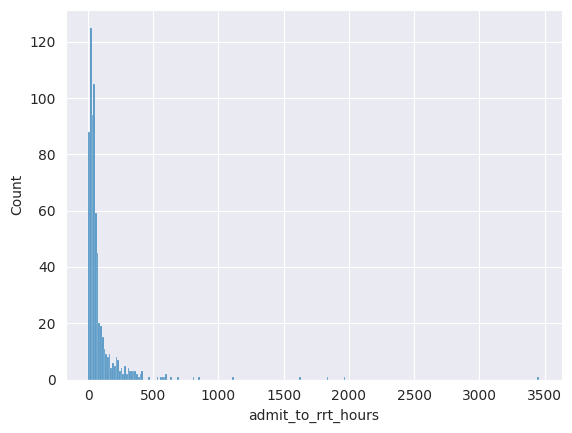

In [14]:
sns.histplot(AKI['admit_to_rrt_hours'])

## Part 2/2 Urine output per weight



### Weight and urine output

I took heart rate to figure out if the patient is actually at the bedside. Only the first 7 days (7*24 hours from admission) of patient stay is considered.

In [15]:
%%bigquery urine_roll_avg --project $PROJECT_ID
with bd_wght as (
SELECT m.visit_occurrence_id, m.value_as_number as body_weight
  FROM measurement m
  WHERE measurement_concept_id in (3026600, 3013762, 3023166, 3025315) -- Body Weight
    AND m.provider_id IS NULL
) ,
-- using the heart rate to determine if a person is at the bedside, gets all hours of stay of a person
-- use "distinct" to remove duplicate entries
hr_hours as (
  select distinct m.person_id, m.visit_occurrence_id,  DATETIME_TRUNC(measurement_datetime, HOUR) rounded_to_hour
  from visit_occurrence v
  inner join measurement m  on m.visit_occurrence_id = v.visit_occurrence_id
  where m.provider_id is not null
    and m.measurement_concept_id = 21490872 -- Heart rate.beat-to-beat by EKG
    and date_diff(v.visit_end_datetime, v.visit_start_datetime, hour)/24.0 >= 2
    and m.measurement_datetime between v.visit_start_datetime
              and timestamp_add (visit_start_datetime, Interval 7*24 hour)
  -- and m.person_id = 12  -- random test
),
-- get all urine output charted. round the measurement time to the nearest hour
-- use "distinct" to remove duplicate entries
urine_hours as (
  select distinct m.person_id, m.visit_occurrence_id, m.value_as_number , m.measurement_datetime
    , DATETIME_TRUNC(measurement_datetime, HOUR) rounded_to_hour
  from measurement m
  inner join visit_occurrence v
  on m.visit_occurrence_id = v.visit_occurrence_id
  and date_diff(v.visit_end_datetime, v.visit_start_datetime, hour)/24.0 >= 2
  where m.measurement_concept_id in (3014315, 3016267, 21491173, 3007123) -- Urine
    and m.provider_id is not null
    and m.measurement_datetime between v.visit_start_datetime and timestamp_add (visit_start_datetime, Interval 7*24 hour)
    and m.value_as_number > 1 -- to avoid possible entries of 0 for "UrineIncontinentie"
  --  and m.person_id = 12 -- test only, random
) ,
-- fill all rows where there is a heart rate but no urine output as zero urine for the hour
urine_fillnull as(
select h.*, ifnull(u.value_as_number,0) as urine_hour
from hr_hours h left outer join urine_hours u
on h.visit_occurrence_id = u.visit_occurrence_id
and h.rounded_to_hour = u.rounded_to_hour
),
-- calculate 6 hour and 12 hour rolling averages
roll_avg as (
select person_id, visit_occurrence_id, rounded_to_hour
, avg(urine_hour) over(partition by visit_occurrence_id order by rounded_to_hour rows between 24 preceding and current row) as avg_24_roll_urine
, avg(urine_hour) over(partition by visit_occurrence_id order by rounded_to_hour rows between 12 preceding and current row) as avg_12_roll_urine
, avg(urine_hour) over(partition by visit_occurrence_id order by rounded_to_hour rows between 6 preceding and current row) as avg_6_roll_urine
from urine_fillnull
)
select a.person_id, a.visit_occurrence_id, w.body_weight
, avg(avg_24_roll_urine/w.body_weight) AS rolling_mean_24h_mL_kg_h
, avg(avg_12_roll_urine/w.body_weight) AS rolling_mean_12h_mL_kg_h
, avg(avg_6_roll_urine/w.body_weight) AS rolling_mean_6h_mL_kg_h
from roll_avg a inner join bd_wght w
on a.visit_occurrence_id = w.visit_occurrence_id
group by a.person_id, a.visit_occurrence_id, w.body_weight


Query is running:   0%|          |

Downloading:   0%|          |

In [16]:
s = urine_roll_avg.select_dtypes(include='object').columns
urine_roll_avg[s] = urine_roll_avg[s].astype("float")

In [17]:
urine_roll_avg.describe()

person_id  visit_occurrence_id  body_weight  \
count        8002.0               8002.0  8002.000000   
mean   10177.788428         11788.356036    79.416396   
std     5846.371362          6777.360001    14.914348   
min             4.0                  4.0    55.000000   
25%         5144.75              5937.75    65.000000   
50%         10198.5              11812.5    75.000000   
75%         15230.0             17635.75    85.000000   
max         20322.0              23548.0   115.000000   

       rolling_mean_24h_mL_kg_h  rolling_mean_12h_mL_kg_h  \
count               8002.000000               8002.000000   
mean                   1.259647                  1.276600   
std                    0.717110                  0.712436   
min                    0.000000                  0.000000   
25%                    0.830253                  0.847975   
50%                    1.194915                  1.214110   
75%                    1.592840                  1.621471   
max                   11.160936                  8.767864   

       rolling_mean_6h_mL_kg_h  
count              8002.000000  
mean                  1.283817  
std                   0.711867  
min                   0.000000  
25%                   0.855823  
50%                   1.227744  
75%                   1.629881  
max                   7.533652

<Axes: xlabel='rolling_mean_6h_mL_kg_h', ylabel='Count'>

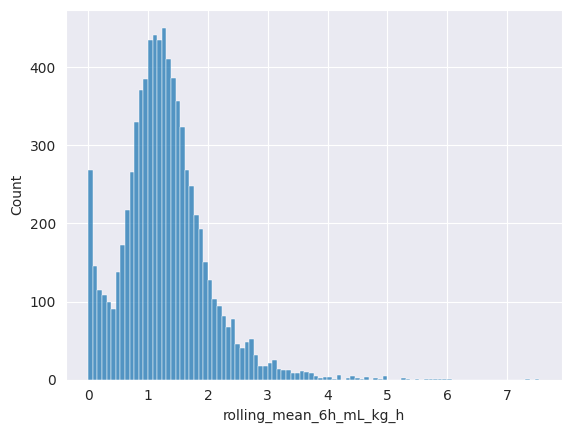

In [18]:
sns.histplot(urine_roll_avg['rolling_mean_6h_mL_kg_h'])

## merge AKI with Urine output

In [19]:
cols_to_use = urine_roll_avg.columns.difference(AKI.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(AKI, urine_roll_avg[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

Clean up to save space

In [20]:
del AKI, urine_roll_avg

In [21]:
s = df.select_dtypes(include='object').columns
df[s] = df[s].astype("float")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7908 entries, 0 to 7907
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   person_id                  7908 non-null   Int64              
 1   visit_occurrence_id        7908 non-null   Int64              
 2   first_scr                  7899 non-null   float64            
 3   highest_scr                7898 non-null   float64            
 4   rrt_procedure_after_admit  7908 non-null   Int64              
 5   rrt_start_date             693 non-null    datetime64[us, UTC]
 6   admit_to_rrt_hours         693 non-null    float64            
 7   body_weight                7666 non-null   float64            
 8   rolling_mean_12h_mL_kg_h   7666 non-null   float64            
 9   rolling_mean_24h_mL_kg_h   7666 non-null   float64            
 10  rolling_mean_6h_mL_kg_h    7666 non-null   float64            
dtypes: I

## Extra conditions for KDIGO

In [22]:

condition_1_mask = (
    (df['rolling_mean_12h_mL_kg_h'] == 0) |
    (df['rolling_mean_24h_mL_kg_h'] < 0.3) |
    (df['highest_scr'] >= df['first_scr'] * 3.0) |
    ((df['highest_scr'] - df['first_scr']) >= 353.6) |
    (df['rrt_start_date'].notnull())
)

condition_2_mask = (
    ~condition_1_mask & (
        ((df['highest_scr'] >= df['first_scr'] * 2.0) & (df['highest_scr'] < df['first_scr'] * 3.0)) |
        (df['rolling_mean_12h_mL_kg_h'] < 0.5)
    )
)

condition_3_mask = (
    ~condition_1_mask & ~condition_2_mask & (
        (df['rolling_mean_6h_mL_kg_h'] < 0.5) |
        ((df['highest_scr'] >= df['first_scr'] * 1.5) & (df['highest_scr'] < df['first_scr'] * 2.0)) |
        ((df['highest_scr'] - df['first_scr']) >= 26.5)
    )
)

df['worst_KDIGO'] = np.select(
    [condition_1_mask, condition_2_mask, condition_3_mask],
    [3, 2, 1],
    default=0
)


<Axes: xlabel='worst_KDIGO', ylabel='Count'>

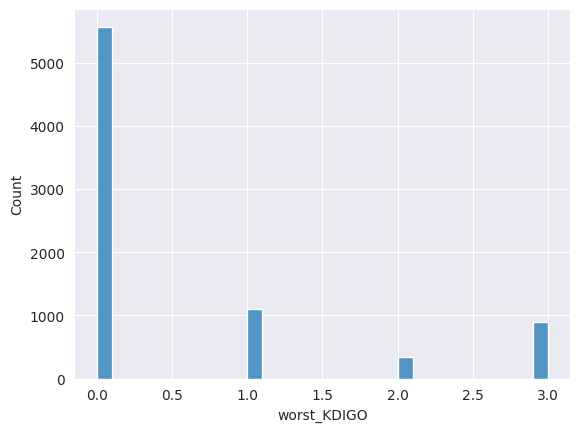

In [23]:
sns.histplot(df['worst_KDIGO'])

### delete those that have no urine output
1. delete those have no baseline creatinine and no highest creatinine
2. delete those that have no rolling 6h urine output

If urine values and body are missing, i think we should drop them. Something would have been wrong with the recording on this case and makes it irrelevant for our learning.  

In [24]:
missing_values_count = df.isna().sum()
sorted_missing_values = missing_values_count.sort_values(ascending=False)
sorted_missing_values

rrt_start_date               7215
admit_to_rrt_hours           7215
body_weight                   242
rolling_mean_12h_mL_kg_h      242
rolling_mean_24h_mL_kg_h      242
rolling_mean_6h_mL_kg_h       242
highest_scr                    10
first_scr                       9
person_id                       0
visit_occurrence_id             0
rrt_procedure_after_admit       0
worst_KDIGO                     0
dtype: int64

In [25]:
df = df[df['rolling_mean_6h_mL_kg_h'].notna()]
df = df[df['first_scr'].notna()]
df = df[df['highest_scr'].notna()]

## Remove columns irrelevant to learning

In [26]:
cols_to_keep = [ 'person_id', 'visit_occurrence_id' #,'first_scr', 'highest_scr'
                , 'admit_to_rrt_hours', 'worst_KDIGO' # both are possible targets for learning
                #, 'rolling_mean_6h_mL_kg_h', 'rolling_mean_12h_mL_kg_h', 'rolling_mean_24h_mL_kg_h'
                ]
df = df.loc[: ,cols_to_keep]

In [27]:
missing_values_count = df.isna().sum()
sorted_missing_values = missing_values_count.sort_values(ascending=False)
sorted_missing_values


admit_to_rrt_hours     7008
person_id                 0
visit_occurrence_id       0
worst_KDIGO               0
dtype: int64

# Other parameters for clustering, where relevant, limit to 7 x 24 hours from visit start
Got them from Ryu's code, modified and included here.
Modified many of them to first value or aggregation over 1 week's values to attempt a different classification.

## demographics


In [28]:
%%bigquery demographics_df --project $PROJECT_ID
WITH Demographics AS (
    SELECT
        vo.person_id,
        vo.visit_occurrence_id,
        EXTRACT(YEAR FROM CURRENT_DATE) - p.year_of_birth AS age,
        CASE WHEN p.gender_concept_id = 8507 THEN 1 -- Male
             WHEN p.gender_concept_id = 8532 THEN 2 -- Female
             ELSE 0 -- Other or unknown
             END AS sex
    FROM
        visit_occurrence vo
    LEFT JOIN
        person p ON vo.person_id = p.person_id
),

HeightMeasurements AS (
    SELECT
        m.person_id,
        CAST(AVG(m.value_as_number) AS FLOAT64) AS avg_height
    FROM
        measurement m
    WHERE
        m.measurement_concept_id IN (3035463, 3023540, 3019171, 3036277) -- height
        AND provider_id IS NULL
        AND m.visit_occurrence_id IS NOT NULL  -- Ensure measurement is linked to a visit
    GROUP BY
        m.person_id
),

WeightMeasurements AS (
    SELECT
        m.person_id,
        CAST(AVG(m.value_as_number) AS FLOAT64) AS avg_weight
    FROM
        measurement m
    WHERE
        m.measurement_concept_id IN (3026600, 3013762, 3023166, 3025315) -- weight
        AND provider_id IS NULL
        AND m.visit_occurrence_id IS NOT NULL  -- Ensure measurement is linked to a visit
    GROUP BY
        m.person_id
)

SELECT
    d.person_id,
    d.visit_occurrence_id,
    d.age,
    d.sex,
    h.avg_height AS height,
    w.avg_weight AS weight,
    CAST(w.avg_weight / (h.avg_height / 100) / (h.avg_height / 100) AS FLOAT64) AS bmi
FROM
    Demographics d
LEFT JOIN
    HeightMeasurements h ON d.person_id = h.person_id
LEFT JOIN
    WeightMeasurements w ON d.person_id = w.person_id


Query is running:   0%|          |

Downloading:   0%|          |

In [29]:
cols_to_use = demographics_df.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, demographics_df[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del demographics_df

## Reason for admission
Modified to remove pivot, just take the reason.

In [30]:
%%bigquery reasons_df --project $PROJECT_ID
/* with r as (
SELECT
  visit_occurrence_id, min(concept_name) as concept_name, 1 as val
FROM
  observation o
  inner join concept c
  on o.value_as_concept_id = c.concept_id
WHERE
  observation_concept_id = 37154585
  AND provider_id IS NOT NULL
group by visit_occurrence_id
)
select * from r
PIVOT ( max(val) for concept_name in ('Emergency', 'Patient Died Before Therapy', 'Scheduled surgical procedure', 'Emergency surgery'))
*/
SELECT
  visit_occurrence_id
  , case when min(concept_name) = 'Scheduled surgical procedure' then 0
         when min(concept_name) = 'Emergency' then 1
         when min(concept_name) = 'Emergency surgery' then 2
         when min(concept_name) = 'Patient Died Before Therapy'then 3
   end
   as reason_for_admission
FROM
  observation o
  inner join concept c
  on o.value_as_concept_id = c.concept_id
WHERE
  observation_concept_id = 37154585
  AND provider_id IS NOT NULL
group by visit_occurrence_id


Query is running:   0%|          |

Downloading:   0%|          |

In [31]:
cols_to_use = reasons_df.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, reasons_df[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del reasons_df

In [32]:
s = df.select_dtypes(include='object').columns
df[s] = df[s].astype("float")

In [33]:
df[cols_to_use] = df[cols_to_use].fillna(0)

## Conditions, procedures

This only gets sepsis on admission, in principle. I have seen deviations in the timestamp, which i cannot explain.  

In [34]:
%%bigquery septic_df --project $PROJECT_ID
SELECT distinct
  visit_occurrence_id,
  1 AS sepsis
FROM
  condition_occurrence o
  inner join concept c on o.condition_concept_id =c.concept_id
WHERE
  condition_concept_id IN (132797, 44820254, 44827180, 1572267, 37394658)
  AND provider_id IS NOT NULL

Query is running:   0%|          |

Downloading:   0%|          |

In [35]:
cols_to_use = septic_df.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, septic_df[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del septic_df

In [36]:
df['sepsis'] = df['sepsis'].fillna(0)

In [37]:
%%bigquery procedures_df --project $PROJECT_ID
with p as (
SELECT distinct
  visit_occurrence_id,
  case when procedure_concept_id = 4148948 then 'Vascular_surgery'
       when procedure_concept_id in (4299602, 4080799) then 'Gastrointestinal_surgery'
       when procedure_concept_id in (4301351, 4159949) then 'General_surgery'
       when procedure_concept_id in (4012185, 4042641) then 'Cardiovascular_surgery'
      end as type_name ,
  1 AS present
FROM
  procedure_occurrence p
  inner join concept c on procedure_concept_id = concept_id
WHERE
  procedure_concept_id IN (
        4148948, -- Vascular_surgery
        4299602, 4080799, -- Gastrointestinal_surgery
        4301351, 4159949, -- General_surgery
        4012185, 4042641 -- Cardiovascular_surgery
  )
  AND provider_id IS NOT NULL
)
select * from p
PIVOT (max(present) for type_name in ('Vascular_surgery', 'Gastrointestinal_surgery', 'General_surgery', 'Cardiovascular_surgery' )
)

Query is running:   0%|          |

Downloading:   0%|          |

In [38]:
cols_to_use = procedures_df.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, procedures_df[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del procedures_df

In [39]:
s = df.select_dtypes(include='object').columns
df[s] = df[s].astype("float")
df[cols_to_use] = df[cols_to_use].fillna(0)

## Previous Comorbidities?

In [40]:
%%bigquery previous_comorbidities_df --project $PROJECT_ID
SELECT
    co.visit_occurrence_id,
    MAX(CASE WHEN co.condition_concept_id = 201254 THEN 1 ELSE 0 END) AS is_type_1_diabetes,
    MAX(CASE WHEN co.condition_concept_id = 316866 AND vo.visit_start_date < co.condition_start_date THEN 1 ELSE 0 END) AS is_hypertension,
    MAX(CASE WHEN co.condition_concept_id IN (37016181, 317576) THEN 1 ELSE 0 END) AS is_coronary_artery_disease,
    MAX(CASE WHEN co.condition_concept_id IN (312723, 319835, 321588, 4281749) AND vo.visit_start_date < co.condition_start_date THEN 1 ELSE 0 END) AS is_heart_disease,
    MAX(CASE WHEN co.condition_concept_id IN (45769564, 4245975) AND vo.visit_start_date < co.condition_start_date THEN 1 ELSE 0 END) AS is_heart_failure,
    MAX(CASE WHEN co.condition_concept_id IN (199744, 4116087, 37168850, 443568, 197230, 439404, 80665
              , 258369, 318096, 198985, 40493428, 35610239, 35610164, 4313916, 196653, 443397, 25189, 443398, 443387, 197508
              , 4180793, 4178968, 4181345, 4147164, 4112853, 4169598, 4181343, 4044013) THEN 1 ELSE 0 END) AS is_cancer
FROM
    condition_occurrence co
JOIN
    visit_occurrence vo ON co.visit_occurrence_id = vo.visit_occurrence_id
WHERE
    co.condition_concept_id IN (201254, 316866, 37016181, 317576, 312723, 319835, 321588, 4281749, 45769564, 4245975, 199744, 4116087, 37168850, 443568, 197230, 439404, 80665, 258369, 318096, 198985, 40493428, 35610239, 35610164, 4313916, 196653, 443397, 25189, 443398, 443387, 197508, 4180793, 4178968, 4181345, 4147164, 4112853, 4169598, 4181343, 4044013)
GROUP BY
    co.visit_occurrence_id;


Query is running:   0%|          |

Downloading:   0%|          |

In [41]:
cols_to_use = previous_comorbidities_df.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, previous_comorbidities_df[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del previous_comorbidities_df

In [42]:
s = df.select_dtypes(include='object').columns
df[s] = df[s].astype("float")
df[cols_to_use] = df[cols_to_use].fillna(0)

## Hemoglobin A1c (NOT USED)

Here there are very few values.
Leave out.

In [43]:
%%bigquery hemoglobin --project $PROJECT_ID
SELECT
    m.visit_occurrence_id
    , approx_quantiles(value_as_number, 100)[offset(50)] as median_HgA1c
FROM
    measurement m inner join visit_occurrence v
    on m.visit_occurrence_id = v.visit_occurrence_id
WHERE
    m.measurement_concept_id = 3004410 -- Hg1Ac
    AND m.provider_id IS NOT NULL
group by m.visit_occurrence_id


Query is running:   0%|          |

Downloading:   0%|          |

In [44]:
# cols_to_use = hemoglobin.columns.difference(df.columns)
# cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
# df = pd.merge(df, hemoglobin[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del hemoglobin

## MAP, median during first week


In [45]:
%%bigquery MAP --project $PROJECT_ID
SELECT
    m.visit_occurrence_id
    , approx_quantiles(value_as_number, 100)[offset(50)] as median_MAP
FROM measurement m inner join visit_occurrence v
    on m.visit_occurrence_id = v.visit_occurrence_id
    and m.measurement_datetime between v.visit_start_datetime and timestamp_add(v.visit_start_datetime , INTERVAL 7*24 hour)
WHERE
    m.measurement_concept_id in (21492241, 21490852) -- mean art press from NIBP or ABP
    AND m.provider_id IS NOT NULL
group by m.visit_occurrence_id


Query is running:   0%|          |

Downloading:   0%|          |

In [46]:
cols_to_use = MAP.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, MAP[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del MAP

## Ventilator, first week
Only 1 week of stay calculated. Trachael indicates intubation during first week. Ventilator values like FiO2 and PEEP are taking for estimating duration days.

In [47]:
%%bigquery vent_pat --project $PROJECT_ID
with tracheal as (
select d.person_id, d.visit_occurrence_id
, count(distinct d.device_exposure_start_date ) as days_trach
, min(device_exposure_start_datetime) as insert_trach
, timestamp_diff(min(device_exposure_start_datetime), visit_start_datetime, hour)/24.0 as days_admit_to_first_trach
  from device_exposure d
inner join concept c2 on d.device_concept_id= c2.concept_id
inner join visit_occurrence v on d.visit_occurrence_id = v.visit_occurrence_id
          -- to limit selection of visits to the same as the AKI criteria, only visits longer than 2 days
          and timestamp_diff(v.visit_end_datetime, v.visit_start_datetime, hour )/24.0 >= 2
where NOT d.provider_id IS NULL -- ignore unvalidated device data
  and c2.concept_id in ( 45772284 -- Tracheostomy tube speech valve
                        ,4097216 -- Endotracheal tube
                        ,4044008 -- Tracheostomy tube
                        ,4208623 -- Double lumen tracheobronchial tube
        )
  -- pick up only tracheal within first 7 days of stay
   and d.device_exposure_start_datetime between v.visit_start_datetime and timestamp_add (v.visit_start_datetime , INTERVAL 7*24 hour)
group by d.person_id, d.visit_occurrence_id, visit_start_datetime
),
vent_pat as (
select m.person_id, m.visit_occurrence_id
      , count(distinct m.measurement_date ) as days_vent -- based on parameters, estimate duration days
      , min(measurement_datetime) as first_date_vent
      , timestamp_diff(min(measurement_datetime), visit_start_datetime, HOUR)/24.0 as days_admit_to_first_vent
  from measurement m
inner join concept c2 on m.measurement_concept_id= c2.concept_id
inner join visit_occurrence v on m.visit_occurrence_id = v.visit_occurrence_id
  and timestamp_diff(v.visit_end_datetime, v.visit_start_datetime, hour )/24.0 >= 2 -- again, filter for visits longer than 2 days
  -- pick up only ventilation within first 7 days of stay
  and m.measurement_datetime between v.visit_start_datetime and timestamp_add (v.visit_start_datetime , INTERVAL 7*24 hour)
where NOT m.provider_id IS NULL -- ignore unvalidated device data
  and c2.concept_id in ( 3004921 -- Ventilation mode Ventilator
                        ,3007646 -- Breath rate spontaneous and mechanical --on ventilator
                        ,3016078 -- Maximum [Pressure] Respiratory system airway opening --during inspiration on ventilator
                        ,21490855 -- PEEP Respiratory system --on ventilator
                        ,3025408 -- Oxygen/Inspired gas Respiratory system by O2 Analyzer --on ventilator
                        ,42527120 -- Expired minute Volume during Mechanical ventilation
                        ,3016166 --Tidal volume inspired spontaneous+mechanical Measured --on ventilator
        )
  and measurement_source_value not like '%Bipap%' -- ignore NIV
  and measurement_source_value not like '%Zephyros%' -- ignore NIV
  and measurement_source_value not like '%(Set)%' -- ignore settings
group by m.person_id, m.visit_occurrence_id, visit_start_datetime
)
select ifnull(v.person_id, t.person_id) as person_id
, ifnull(v.visit_occurrence_id, t.visit_occurrence_id) as visit_occurrence_id
-- , first_date_vent
, days_trach
, days_admit_to_first_vent
, days_vent
-- , insert_trach
, days_admit_to_first_trach
from vent_pat v full outer join tracheal t
on v.visit_occurrence_id = t.visit_occurrence_id


Query is running:   0%|          |

Downloading:   0%|          |

In [48]:
vent_pat = vent_pat.fillna(0)

In [49]:
cols_to_use = vent_pat.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, vent_pat[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del vent_pat

In [50]:
df[cols_to_use] = df[cols_to_use].fillna(0)

## Nephrotoxic drugs, days of exposure within first week


In [51]:
%%bigquery antiinflammatory_nephrotoxic --project $PROJECT_ID
With nephro as (
SELECT
  e.person_id, e.visit_occurrence_id
  , case when concept_id in (40162347, 40162352) then 'Diclofenac'
       else 'others' end as drug_name
  , count(DISTINCT drug_exposure_start_date ) AS days_antiinflamm
FROM
  drug_exposure e
inner join concept c
   on e.drug_concept_id = c.concept_id
inner join visit_occurrence v
on e.visit_occurrence_id = v.visit_occurrence_id
and timestamp_diff( visit_end_datetime, visit_start_datetime, hour )/24.0 > 2
-- pick up only within first 7 days of stay
   and e.drug_exposure_start_datetime
         between v.visit_start_datetime and timestamp_add (v.visit_start_datetime , INTERVAL 7*24 hour)
WHERE
  drug_concept_id IN (40162347, 40162352)
GROUP BY
  e.person_id, e.visit_occurrence_id, drug_name
)
select * from nephro
PIVOT (sum(days_antiinflamm)
for drug_name in ('Diclofenac'))

Query is running:   0%|          |

Downloading:   0%|          |

In [52]:
cols_to_use = antiinflammatory_nephrotoxic.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, antiinflammatory_nephrotoxic[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

df[cols_to_use] = df[cols_to_use].fillna(0)
del antiinflammatory_nephrotoxic

In [53]:
%%bigquery antibiotic_nephrotoxic --project $PROJECT_ID
With nephro as (
SELECT
  e.person_id, e.visit_occurrence_id
  , case when concept_id in (36258242) then 'Amikacin'
         when concept_id in (35604141, 40747347, 41239210, 1717240, 35830173) then 'Amphotericin'
         when concept_id in (901845, 40025432, 40241491) then 'Colistin'
         when concept_id in (44086327) then 'Gentamicin'
         when concept_id in (40902269, 40933447) then 'Sulfamethoxazole'
         when concept_id in (43295826) then 'Vancomycin'
       else 'others' end as drug_name
  , count(DISTINCT drug_exposure_start_date) AS days_antibiotic
FROM
  drug_exposure e
inner join concept c
   on e.drug_concept_id = c.concept_id
inner join visit_occurrence v
on e.visit_occurrence_id = v.visit_occurrence_id
and timestamp_diff( visit_end_datetime, visit_start_datetime, hour )/24.0 > 2
-- pick up only within first 7 days of stay
   and e.drug_exposure_start_datetime
         between v.visit_start_datetime and timestamp_add (v.visit_start_datetime , INTERVAL 7*24 hour)
WHERE
  drug_concept_id IN (43295826, 35604141, 35830173, 41239210, 40747347, 1717240, 44086327, 36258242, 40025432, 40241491, 901845, 40933447, 40902269)
GROUP BY
  e.person_id, e.visit_occurrence_id, drug_name
)
select * from nephro
PIVOT (sum(days_antibiotic)
for drug_name in ('Amikacin', 'Amphotericin', 'Colistin', 'Gentamicin', 'Sulfamethoxazole', 'Vancomycin'))

Query is running:   0%|          |

Downloading:   0%|          |

In [54]:
cols_to_use = antibiotic_nephrotoxic.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, antibiotic_nephrotoxic[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del antibiotic_nephrotoxic

In [55]:
%%bigquery diuretic_nephrotoxic --project $PROJECT_ID
With nephro as (
SELECT
  e.person_id, e.visit_occurrence_id
  , case when concept_id in (40014781, 932749) then 'Bumetanide'
         when concept_id in (36275764, 19023791) then 'Furosemide'
       else 'others' end as drug_name
  , count(distinct drug_exposure_start_date ) AS days_diuretic
FROM
  drug_exposure e
inner join concept c
   on e.drug_concept_id = c.concept_id
inner join visit_occurrence v
on e.visit_occurrence_id = v.visit_occurrence_id
and timestamp_diff( visit_end_datetime, visit_start_datetime, hour )/24.0 > 2
-- pick up only within first 7 days of stay
   and e.drug_exposure_start_datetime
         between v.visit_start_datetime and timestamp_add (v.visit_start_datetime , INTERVAL 7*24 hour)
WHERE
  drug_concept_id IN (40014781, 932749, 36275764, 19023791)
GROUP BY
  e.person_id, e.visit_occurrence_id, drug_name
)
select * from nephro
PIVOT (sum(days_diuretic)
for drug_name in ('Bumetanide', 'Furosemide'))

Query is running:   0%|          |

Downloading:   0%|          |

In [56]:
cols_to_use = diuretic_nephrotoxic.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, diuretic_nephrotoxic[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del diuretic_nephrotoxic

In [57]:
%%bigquery Antihypertensive_nephrotoxic --project $PROJECT_ID
With nephro as (
SELECT
  e.person_id, e.visit_occurrence_id
  , case when concept_id in (40039228) then 'Fosinopril'
         when concept_id in (43191848) then 'Enalaprilaat'
         when concept_id in (1340161) then 'Captopril'
         when concept_id in (21021365) then 'Perindopril'
         when concept_id in (19003829) then 'Lisinopril'
         when concept_id in (21141441) then 'Irbesartan'
         when concept_id in (40100659) then 'Valsartan'
         when concept_id in (40095734) then 'Candesartan'
         when concept_id in (40000896) then 'Losartan'
       else 'others' end as drug_name
  , count(distinct drug_exposure_start_date ) AS days_antihypertensive
FROM
  drug_exposure e
inner join concept c
   on e.drug_concept_id = c.concept_id
inner join visit_occurrence v
on e.visit_occurrence_id = v.visit_occurrence_id
and timestamp_diff( visit_end_datetime, visit_start_datetime, hour )/24.0 > 2
-- pick up only within first 7 days of stay
   and e.drug_exposure_start_datetime
         between v.visit_start_datetime and timestamp_add (v.visit_start_datetime , INTERVAL 7*24 hour)
WHERE
  drug_concept_id IN (40039228, 43191848, 1340161, 21021365, 19003829, 21141441, 40100659, 40095734, 40000896)
GROUP BY
  e.person_id, e.visit_occurrence_id, drug_name
)
select * from nephro
PIVOT (sum(days_antihypertensive)
for drug_name in ('Fosinopril', 'Enalaprilaat', 'Captopril', 'Perindopril', 'Lisinopril', 'Irbesartan', 'Valsartan', 'Candesartan','Losartan' ))


Query is running:   0%|          |

Downloading:   0%|          |

In [58]:
cols_to_use = Antihypertensive_nephrotoxic.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, Antihypertensive_nephrotoxic[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del Antihypertensive_nephrotoxic

## BGA, median in first week
Added a summary of BGA labs during 1 week by median value, arterial only. Since some of the labs on first day were empty, i thought this may improve classification.

In [59]:
%%bigquery bga --project $PROJECT_ID
with BGA as (
select m.visit_occurrence_id
, case when measurement_concept_id = 3010421 then 'pH'
     when measurement_concept_id = 3027315 then 'PaO2'
		 when measurement_concept_id = 3013290 then 'PaCO2'
		 when measurement_concept_id = 3006576 then 'HCO3'
		 when measurement_concept_id = 3012501 then 'BE'
		 when measurement_concept_id = 3047181 then 'Lactate'
     when measurement_concept_id = 3007930 then 'MetHb'
		 when measurement_concept_id = 3023081 then 'CoHb'
		 when measurement_concept_id = 3014646 then 'HbO2'
		 when measurement_concept_id = 40762351 then 'Hb'
		 when measurement_concept_id = 42869608 then 'tHb'
     when measurement_concept_id = 3044904 then 'O2CT'
		 when measurement_concept_id = 3000285 then 'Na'
		 when measurement_concept_id = 3005456 then 'K'
		 when measurement_concept_id = 3018572 then 'Cl'
		 when measurement_concept_id = 3021119 then 'Ca'
		 when measurement_concept_id = 3020491 then 'Glucose'
		 when measurement_concept_id = 3039000 then 'AGap'
		 when measurement_concept_id = 42869588 then 'HCT'
end as measurement_name
, APPROX_QUANTILES(m.value_as_number, 100)[offset(50)] value_as_number
from measurement m
inner join specimen s
        on m.person_id = s.person_id
        and m.measurement_datetime = s.specimen_datetime
        and s.specimen_concept_id in (4047496 -- arterial only!
        )
inner join visit_occurrence v
	 on m.visit_occurrence_id = v.visit_occurrence_id
-- only visits longer than 2 days included
   and timestamp_diff( visit_end_datetime, visit_start_datetime, hour )/24.0 > 2
-- pick up only within first 7 days of stay
   and m.measurement_datetime
        between v.visit_start_datetime and timestamp_add (v.visit_start_datetime , INTERVAL 7*24 hour)
where NOT m.provider_id IS NULL -- ignore unvalidated device data
  and m.measurement_type_concept_id = 32856 -- Lab only so we get consistent data
  and m.measurement_concept_id in (
											3010421 -- pH of Blood
											,3027315 -- Oxygen [Partial pressure] in Blood
											,3013290 -- Carbon dioxide [Partial pressure] in Blood
											,3006576 -- Bicarbonate [Moles/volume] in Blood
											,3012501 -- Base excess in Blood by calculation
											,3047181 -- Lactate [Moles/volume] in Blood
											,3007930 -- Methemoglobin/Hemoglobin.total in Blood
											,3023081 -- Carboxyhemoglobin/Hemoglobin.total in Blood
											,3014646 -- Fractional oxyhemoglobin in Blood
											,40762351 -- Hemoglobin [Moles/volume] in Blood
											,42869608 -- Oxygen saturation [Pure mass fraction] in Blood
											,3044904 -- Oxygen content in Blood
											,3000285 -- Sodium [Moles/volume] in Blood
											,3005456 -- Potassium [Moles/volume] in Blood
											,3018572 -- Chloride [Moles/volume] in Blood
											,3021119 -- Calcium.ionized [Moles/volume] in Blood
											,3020491 -- Glucose [Moles/volume] in Blood
											,3039000 -- Anion gap in Blood
											,42869588 -- Hematocrit [Pure volume fraction] of Blood by Automated count
	)
group by m.visit_occurrence_id , measurement_concept_id
)
select * from bga t  -- pivot of all the BGA measures
      pivot ( max(t.value_as_number) for t.measurement_name in (
        'Lactate', 'pH', 'O2CT', 'BE', 'MetHb', 'HbO2', 'HCT', 'Hb', 'CoHb', 'tHb', 'AGap', 'Glucose', 'PaO2', 'PaCO2', 'HCO3', 'Na', 'K', 'Cl'))


Query is running:   0%|          |

Downloading:   0%|          |

In [60]:
cols_to_use = bga.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, bga[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del bga

In [61]:
s = df.select_dtypes(include='object').columns
df[s] = df[s].astype("float")


## antibiotic not nephrotoxic
Boolean flag. When exposure during first week more than 2 days then 1 else 0.

In [62]:
%%bigquery non_nephro --project $PROJECT_ID
SELECT
  e.visit_occurrence_id
  , CASE WHEN count(distinct drug_exposure_start_date) >= 2 THEN 1 ELSE 0 END AS is_antibiotic_not
FROM
  drug_exposure e
inner join visit_occurrence v
on e.visit_occurrence_id = v.visit_occurrence_id
and timestamp_diff( visit_end_datetime, visit_start_datetime, hour )/24.0 > 2
-- pick up only within first 7 days of stay
and e.drug_exposure_start_datetime
         between v.visit_start_datetime and timestamp_add (v.visit_start_datetime , INTERVAL 7*24 hour)
WHERE
  drug_concept_id IN (40731671, 40730323, 40077149, 36881808, 40928582, 35154887, 44125439, 41129017, 40062625, 42620284, 42479695, 40736877)
GROUP BY
  e.visit_occurrence_id


Query is running:   0%|          |

Downloading:   0%|          |

In [63]:
cols_to_use = non_nephro.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, non_nephro[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del non_nephro

## Crystalloid, sum qty in first week

In [64]:
%%bigquery crystalloid --project $PROJECT_ID
SELECT
  e.visit_occurrence_id,
  SUM(quantity) AS crystalloid
FROM
  drug_exposure e
inner join visit_occurrence v
on e.visit_occurrence_id = v.visit_occurrence_id
and timestamp_diff( visit_end_datetime, visit_start_datetime, hour )/24.0 > 2
-- pick up only within first 7 days of stay
and e.drug_exposure_start_datetime
         between v.visit_start_datetime and timestamp_add (v.visit_start_datetime , INTERVAL 7*24 hour)
WHERE
  drug_concept_id IN (40709262, 40221384, 40221387, 4305895, 21040129)
GROUP BY
  visit_occurrence_id
having count(distinct drug_exposure_start_date) <= 2

Query is running:   0%|          |

Downloading:   0%|          |

In [65]:
cols_to_use = crystalloid.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, crystalloid[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del crystalloid

## Synthetic Colloid, boolean flag if present in first week

In [66]:
%%bigquery syn_crystalloid --project $PROJECT_ID
SELECT
  e.visit_occurrence_id,
  CASE WHEN COUNT(*) > 0 THEN 1 ELSE 0 END AS is_synthetic_colloid
FROM
  drug_exposure e
inner join visit_occurrence v
on e.visit_occurrence_id = v.visit_occurrence_id
and timestamp_diff( visit_end_datetime, visit_start_datetime, hour )/24.0 > 2
-- pick up only within first 7 days of stay
and e.drug_exposure_start_datetime
         between v.visit_start_datetime and timestamp_add (v.visit_start_datetime , INTERVAL 7*24 hour)
WHERE
  e.drug_concept_id IN (1718299, 21118561)
GROUP BY
  e.visit_occurrence_id

Query is running:   0%|          |

Downloading:   0%|          |

In [67]:
cols_to_use = syn_crystalloid.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, syn_crystalloid[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del syn_crystalloid

## Albumin, boolean flag if present in first week

In [68]:
%%bigquery albumin --project $PROJECT_ID
SELECT
  e.visit_occurrence_id,
  CASE WHEN COUNT(*) > 0 THEN 1 ELSE 0 END AS is_albumin
FROM
  drug_exposure e
inner join visit_occurrence v
on e.visit_occurrence_id = v.visit_occurrence_id
and timestamp_diff( visit_end_datetime, visit_start_datetime, hour )/24.0 > 2
-- pick up only within first 7 days of stay
and e.drug_exposure_start_datetime
         between v.visit_start_datetime and timestamp_add (v.visit_start_datetime , INTERVAL 7*24 hour)
WHERE
  e.drug_concept_id = 42482688
GROUP BY
  e.visit_occurrence_id

Query is running:   0%|          |

Downloading:   0%|          |

In [69]:
cols_to_use = albumin.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, albumin[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del albumin

## Norephinephrine, sum qty in first week


In [70]:
%%bigquery norepinephrine --project $PROJECT_ID
SELECT
  e.visit_occurrence_id,
  SUM(quantity) AS sum_norepinephrine_qty
FROM drug_exposure e
inner join visit_occurrence v
on e.visit_occurrence_id = v.visit_occurrence_id
and timestamp_diff( visit_end_datetime, visit_start_datetime, hour )/24.0 > 2
-- pick up only within first 7 days of stay
and e.drug_exposure_start_datetime
         between v.visit_start_datetime and timestamp_add (v.visit_start_datetime , INTERVAL 7*24 hour)
WHERE
  e.drug_concept_id IN (40072394, 2907531)
GROUP BY
  e.visit_occurrence_id

Query is running:   0%|          |

Downloading:   0%|          |

In [71]:
cols_to_use = norepinephrine.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, norepinephrine[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del norepinephrine

## Dobutamine, sum qty in first week and median ml/hour rate

In [72]:
%%bigquery dobutamine --project $PROJECT_ID
SELECT e.visit_occurrence_id
, approx_quantiles(cast (substring(sig,strpos(sig, '=')+1, strpos(sig, 'ml/uur')-strpos(sig, '=')-1 ) as NUMERIC),100)[offset(50)]  as dobutamine_median_ml_hr
, sum(quantity) AS dobutamine_sum_qty
FROM drug_exposure e
inner join visit_occurrence v
on e.visit_occurrence_id = v.visit_occurrence_id
and timestamp_diff( visit_end_datetime, visit_start_datetime, hour )/24.0 > 2
-- pick up only within first 7 days of stay
and e.drug_exposure_start_datetime
         between v.visit_start_datetime and timestamp_add (v.visit_start_datetime , INTERVAL 7*24 hour)
WHERE e.drug_concept_id = 21088391
GROUP BY e.visit_occurrence_id


Query is running:   0%|          |

Downloading:   0%|          |

In [73]:
cols_to_use = dobutamine.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, dobutamine[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del dobutamine

## Dopamine, sum qty in first week and median ml/hour rate

In [74]:
%%bigquery dopamine --project $PROJECT_ID
SELECT e.visit_occurrence_id
, approx_quantiles(cast (substring(sig,strpos(sig, '=')+1, strpos(sig, 'ml/uur')-strpos(sig, '=')-1 ) as NUMERIC),100)[offset(50)]  as dopamine_median_ml_hr
, sum(quantity) AS dopamine_sum_qty
FROM drug_exposure e
inner join visit_occurrence v
on e.visit_occurrence_id = v.visit_occurrence_id
and timestamp_diff( visit_end_datetime, visit_start_datetime, hour )/24.0 > 2
-- pick up only within first 7 days of stay
and e.drug_exposure_start_datetime
         between v.visit_start_datetime and timestamp_add (v.visit_start_datetime , INTERVAL 7*24 hour)
WHERE e.drug_concept_id = 36411287
GROUP BY e.visit_occurrence_id


Query is running:   0%|          |

Downloading:   0%|          |

In [75]:
cols_to_use = dopamine.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, dopamine[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del dopamine

## Vasodilator, sum in first week of visit

In [76]:
%%bigquery Vasodilator --project $PROJECT_ID
SELECT  e.visit_occurrence_id,
  SUM(quantity) AS iv_vasodilator
FROM   drug_exposure e
inner join visit_occurrence v
on e.visit_occurrence_id = v.visit_occurrence_id
and timestamp_diff( visit_end_datetime, visit_start_datetime, hour )/24.0 > 2
-- pick up only within first 7 days of stay
and e.drug_exposure_start_datetime
         between v.visit_start_datetime and timestamp_add (v.visit_start_datetime , INTERVAL 7*24 hour)
WHERE   e.drug_concept_id IN (35132166, 43801317)
GROUP BY   e.visit_occurrence_id

Query is running:   0%|          |

Downloading:   0%|          |

In [77]:
cols_to_use = Vasodilator.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, Vasodilator[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del Vasodilator

## Labs on day, max on day 1
Code came from Ryu originally. These are the max labs, regardless of specimen source, during the first 24 hours of stay of a visit.

In [78]:
%%bigquery lab_data_1 --project $PROJECT_ID
SELECT
    m.visit_occurrence_id,
    MAX(CASE WHEN measurement_concept_id = 40762351 THEN CAST(value_as_number AS FLOAT64) END) AS hemoglobin_moles_volume_in_blood,
    MAX(CASE WHEN measurement_concept_id = 42869588 THEN CAST(value_as_number AS FLOAT64) END) AS hematocrit_pure_volume_fraction_of_blood_by_automated_count,
    MAX(CASE WHEN measurement_concept_id = 3023103 THEN CAST(value_as_number AS FLOAT64) END) AS potassium_moles_volume_in_serum_or_plasma,
    MAX(CASE WHEN measurement_concept_id = 3005456 THEN CAST(value_as_number AS FLOAT64) END) AS potassium_moles_volume_in_blood,
    MAX(CASE WHEN measurement_concept_id = 43534077 THEN CAST(value_as_number AS FLOAT64) END) AS urea_moles_volume_in_blood,
    MAX(CASE WHEN measurement_concept_id = 3010421 THEN CAST(value_as_number AS FLOAT64) END) AS ph_of_blood,
    MAX(CASE WHEN measurement_concept_id = 3014111 THEN CAST(value_as_number AS FLOAT64) END) AS lactate_moles_volume_in_serum_or_plasma,
    MAX(CASE WHEN measurement_concept_id = 3047181 THEN CAST(value_as_number AS FLOAT64) END) AS lactate_moles_volume_in_blood,
    MAX(CASE WHEN measurement_concept_id = 3006576 THEN CAST(value_as_number AS FLOAT64) END) AS bicarbonate_moles_volume_in_blood,
    MAX(CASE WHEN measurement_concept_id = 3046279 THEN CAST(value_as_number AS FLOAT64) END) AS procalcitonin_mass_volume_in_serum_or_plasma,
    MAX(CASE WHEN measurement_concept_id = 3035320 THEN CAST(value_as_number AS FLOAT64) END) AS c_reactive_protein_mass_volume_in_body_fluid,
    MAX(CASE WHEN measurement_concept_id = 3020460 THEN CAST(value_as_number AS FLOAT64) END) AS c_reactive_protein_mass_volume_in_serum_or_plasma,
    MAX(CASE WHEN measurement_concept_id = 3029187 THEN CAST(value_as_number AS FLOAT64) END) AS natriuretic_peptide_b_prohormone_n_terminal_mass_volume_in_serum_or_plasma,
    MAX(CASE WHEN measurement_concept_id = 3000285 THEN CAST(value_as_number AS FLOAT64) END) AS sodium_moles_volume_in_blood,
    MAX(CASE WHEN measurement_concept_id = 3019550 THEN CAST(value_as_number AS FLOAT64) END) AS sodium_moles_volume_in_serum_or_plasma,
    MAX(CASE WHEN measurement_concept_id = 3024928 THEN CAST(value_as_number AS FLOAT64) END) AS oxygen_saturation_in_venous_blood,
    MAX(CASE WHEN measurement_concept_id = 3020491 THEN CAST(value_as_number AS FLOAT64) END) AS glucose_moles_volume_in_blood,
    MAX(CASE WHEN measurement_concept_id = 3007220 THEN CAST(value_as_number AS FLOAT64) END) AS creatine_kinase_enzymatic_activity_volume_in_serum_or_plasma,
    MAX(CASE WHEN measurement_concept_id = 40757494 THEN CAST(value_as_number AS FLOAT64) END) AS bilirubin_total_moles_volume_in_blood,
    MAX(CASE WHEN measurement_concept_id = 3006140 THEN CAST(value_as_number AS FLOAT64) END) AS bilirubin_total_moles_volume_in_serum_or_plasma
FROM
    measurement m
JOIN
    visit_occurrence v ON m.visit_occurrence_id = v.visit_occurrence_id
    and timestamp_diff( visit_end_datetime, visit_start_datetime, hour )/24.0 > 2
    -- pick up only within first 7 days of stay
    and m.measurement_datetime
         between v.visit_start_datetime and timestamp_add (v.visit_start_datetime , INTERVAL 7*24 hour)
WHERE
    measurement_concept_id IN (40762351, 42869588, 3024561, 3023103, 3005456, 43534077, 3010421, 3014111, 3047181, 3006576, 3046279, 3035320, 3020460, 3029187, 3000285, 3019550, 3024928, 3020491, 3007220, 40757494, 3006140)
    AND m.measurement_datetime between v.visit_start_datetime and timestamp_add(v.visit_start_datetime, INTERVAL 24 HOUR)
    AND m.provider_id IS NOT NULL
GROUP BY
    m.visit_occurrence_id



Query is running:   0%|          |

Downloading:   0%|          |

In [79]:
cols_to_use = lab_data_1.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, lab_data_1[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del lab_data_1

## Albumin first lab
This is the first lab measurement of  albumin mass volume in serum or plasma of a visit.

In [80]:
%%bigquery lab_data_2 --project $PROJECT_ID
SELECT m.visit_occurrence_id,
       CAST(value_as_number AS FLOAT64) AS albumin_mass_volume_in_serum_or_plasma
FROM measurement m
JOIN visit_occurrence v ON m.visit_occurrence_id = v.visit_occurrence_id
    and timestamp_diff( visit_end_datetime, visit_start_datetime, hour )/24.0 > 2
    -- pick up only within first 7 days of stay
    and m.measurement_datetime
         between v.visit_start_datetime and timestamp_add (v.visit_start_datetime , INTERVAL 7*24 hour)
WHERE measurement_concept_id = 3024561
AND m.provider_id IS NOT NULL
qualify row_number() over (partition by m.visit_occurrence_id order by measurement_datetime) = 1

Query is running:   0%|          |

Downloading:   0%|          |

In [81]:
cols_to_use = lab_data_2.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, lab_data_2[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del lab_data_2

## Ventilator value, first

3020716 inhaled_oxygen_concentration, first value

In [82]:
%%bigquery inhaled_O2_conc --project $PROJECT_ID
SELECT visit_occurrence_id,
       CAST(value_as_number AS FLOAT64) AS inhaled_oxygen_concentration
FROM measurement
WHERE measurement_concept_id = 3020716
AND provider_id IS NOT NULL
qualify row_number() over (partition by visit_occurrence_id order by measurement_datetime) = 1

Query is running:   0%|          |

Downloading:   0%|          |

In [83]:
cols_to_use = inhaled_O2_conc.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, inhaled_O2_conc[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del inhaled_O2_conc

## first SvO2
Get the first oxygen saturation in blood from venous specimen sample of a visit.

In [84]:
%%bigquery SvO2 --project $PROJECT_ID
select m.person_id, m.visit_occurrence_id
, case when m.value_as_number < 1 then m.value_as_number * 100 else m.value_as_number end
     as first_SvO2
from measurement m
inner join specimen s
  on m.person_id = s.person_id
  and m.measurement_datetime = s.specimen_datetime -- specimen info at same time as measurement
inner join concept c
  on s.specimen_concept_id = c.concept_id
  and ( c.concept_name like '%Venous%' -- bigquery is case sensitive.
        or c.concept_name like '%venous%')
inner join visit_occurrence v
on m.visit_occurrence_id = v.visit_occurrence_id
and timestamp_diff(v.visit_end_datetime, v.visit_start_datetime, hour)/24.0 >= 2 -- only visits more than 2 days
where NOT m.provider_id IS NULL -- ignore unvalidated device data
  and m.measurement_concept_id in (
											42869608 -- Oxygen saturation [Pure mass fraction] in Blood
											,3044904 -- Oxygen content in Blood
	)
  and m.measurement_datetime between v.visit_start_datetime and timestamp_add (v.visit_start_datetime, interval 24 hour)
qualify row_number() over (partition by visit_occurrence_id order by measurement_datetime) = 1


Query is running:   0%|          |

Downloading:   0%|          |

In [85]:
cols_to_use = SvO2.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, SvO2[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del SvO2

## first CRP
Get the first C reative protein measurement from a visit.  

In [86]:
%%bigquery CRP --project $PROJECT_ID
select m.person_id, m.visit_occurrence_id
, case when m.value_as_number < 1 then m.value_as_number * 100 else m.value_as_number end as first_CRP
from measurement m
inner join visit_occurrence v
on m.visit_occurrence_id = v.visit_occurrence_id
and timestamp_diff(v.visit_end_datetime, v.visit_start_datetime, hour)/24.0 >= 2 -- only visits more than 2 days
where NOT m.provider_id IS NULL -- ignore unvalidated device data
  and m.measurement_concept_id in (
											3035320 -- C reactive protein [Mass/volume] in Body fluid -- this has only three values
                    , 3020460 -- C reactive protein [Mass/volume] in Serum or Plasma -- this has a lot more! the dutch name looks correct.
	)
and m.measurement_datetime between v.visit_start_datetime and timestamp_add (v.visit_start_datetime, interval 24 hour)
qualify row_number() over (partition by visit_occurrence_id order by measurement_datetime) = 1


Query is running:   0%|          |

Downloading:   0%|          |

In [87]:
cols_to_use = CRP.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, CRP[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del CRP

## LOS days

Calculate length of stay days by subtracting visit start time from visit end time as hours divided by 24.0 to get a decimal length of stay days.

In [88]:
%%bigquery LOS_days --project $PROJECT_ID
SELECT
    visit_occurrence_id,
    timestamp_DIFF(visit_end_datetime, visit_start_datetime, HOUR)/24.0 AS length_of_stay_days
FROM
    visit_occurrence;

Query is running:   0%|          |

Downloading:   0%|          |

In [89]:
cols_to_use = LOS_days.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, LOS_days[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del LOS_days

## Death
Boolean flag. Marked died=1 if the time of death is after visit start date time.

In [90]:
%%bigquery death --project $PROJECT_ID
SELECT v.person_id, v.visit_occurrence_id,
timestamp_diff(death_datetime, v.visit_start_datetime, hour)/24.0 as days_admit_to_death,
1 as died
FROM visit_occurrence v
inner JOIN death d ON v.person_id = d.person_id
   and d.death_datetime >= v.visit_start_datetime -- use this if only identify stays that ended in death


Query is running:   0%|          |

Downloading:   0%|          |

In [91]:
cols_to_use = death.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, death[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')

del death

In [92]:
df['died'] = df['died'].fillna(0)

## total RRT days during visit
total count of RRT days based on dialysis measurements between visit start and visit end times.

In [93]:
%%bigquery RRT_days --project $PROJECT_ID
SELECT m.person_id, m.visit_occurrence_id
, count(distinct measurement_date) as days_in_RRT -- all days of rrt in duration of visit
-- , visit_start_datetime -- for checking purpose
-- , min(measurement_datetime) as first_rrt_date -- datetime of the first charting of any of the terms
, timestamp_diff(min(measurement_datetime), visit_start_datetime, hour )/24.0 as days_to_start_RRT -- number of days from admission to first RRT
from measurement m
inner join visit_occurrence v on m.visit_occurrence_id = v.visit_occurrence_id
    -- pick up only within first 7 days of stay
    and m.measurement_datetime
         between v.visit_start_datetime and timestamp_add (v.visit_start_datetime , INTERVAL 7*24 hour)
where measurement_concept_id in ( 44802820 -- Haemodialysis ultrafiltration rate
                                , 44802821 -- Haemodialysis ultrafiltration volume
                                , 1988590  -- Ultrafiltrate volume removed
                                , 4089846  -- Ultrafiltrate fluid loss
                                , 40493256 -- Duration of hemodialysis session
                                , 44813196 -- Dialysate temperature
)
  and m.measurement_datetime between v.visit_start_datetime and v.visit_end_datetime
  and m.provider_id IS NOT NULL
  and value_as_number > 0
--  and m.visit_occurrence_id = 14749
group by m.visit_occurrence_id, m.person_id, visit_start_datetime


Query is running:   0%|          |

Downloading:   0%|          |

In [94]:
cols_to_use = RRT_days.columns.difference(df.columns)
cols_to_use = cols_to_use.insert( 0,'visit_occurrence_id')
df = pd.merge(df, RRT_days[cols_to_use], how='left', left_on='visit_occurrence_id', right_on='visit_occurrence_id')
df[cols_to_use] = df[cols_to_use].fillna(0)
del RRT_days

# Post-processing check nulls


In [95]:
s = df.select_dtypes(include='object').columns
df[s] = df[s].astype("float")

In [96]:
df.describe()

person_id  visit_occurrence_id  admit_to_rrt_hours  worst_KDIGO  \
count       7664.0               7664.0          656.000000  7664.000000   
mean   10169.50548         11778.710204           91.734934     0.560804   
std    5846.419527          6777.434178          196.117056     1.002259   
min            4.0                  4.0            1.466667     0.000000   
25%         5108.5               5893.5           24.066667     0.000000   
50%        10198.5              11812.5           46.583333     0.000000   
75%        15218.5              17623.5           82.487500     1.000000   
max        20322.0              23548.0         3458.333333     3.000000   

             age          bmi       height       sex       weight  \
count     7664.0  7544.000000  7544.000000    7664.0  7664.000000   
mean   76.591336    25.800770   175.262770  1.340292    79.275405   
std    16.278657     4.335087     9.526981  0.504517    14.584814   
min         41.0    16.070124   155.000000       0.0    55.000000   
25%         66.0    22.892820   165.000000       1.0    65.000000   
50%         76.0    24.835646   175.000000       1.0    75.000000   
75%         86.0    27.755102   185.000000       2.0    85.000000   
max        103.0    47.866805   195.000000       2.0   115.000000   

       reason_for_admission    sepsis  Cardiovascular_surgery  \
count                7664.0    7664.0                  7664.0   
mean               0.494911  0.091075                0.087944   
std                0.661363  0.287735                0.283231   
min                     0.0       0.0                     0.0   
25%                     0.0       0.0                     0.0   
50%                     0.0       0.0                     0.0   
75%                     1.0       0.0                     0.0   
max                     2.0       1.0                     1.0   

       Gastrointestinal_surgery  General_surgery  Vascular_surgery  is_cancer  \
count                    7664.0           7664.0            7664.0     7664.0   
mean                   0.008481         0.096555           0.02727   0.048408   
std                    0.091708         0.295371          0.162881   0.214641   
min                         0.0              0.0               0.0        0.0   
25%                         0.0              0.0               0.0        0.0   
50%                         0.0              0.0               0.0        0.0   
75%                         0.0              0.0               0.0        0.0   
max                         1.0              1.0               1.0        1.0   

       is_coronary_artery_disease  is_heart_disease  is_heart_failure  \
count                      7664.0            7664.0            7664.0   
mean                     0.075678               0.0               0.0   
std                        0.2645               0.0               0.0   
min                           0.0               0.0               0.0   
25%                           0.0               0.0               0.0   
50%                           0.0               0.0               0.0   
75%                           0.0               0.0               0.0   
max                           1.0               0.0               0.0   

       is_hypertension  is_type_1_diabetes   median_MAP  \
count           7664.0              7664.0  7664.000000   
mean               0.0                 0.0    83.280532   
std                0.0                 0.0    10.434242   
min                0.0                 0.0    50.000000   
25%                0.0                 0.0    76.000000   
50%                0.0                 0.0    82.000000   
75%                0.0                 0.0    89.000000   
max                0.0                 0.0   136.000000   

       days_admit_to_first_trach  days_admit_to_first_vent  days_trach  \
count                7664.000000               7664.000000      7664.0   
mean                    0.075032                

In [97]:
df.query('person_id == 20260')  # check a random case

<ipython-input-97-73ff2ac39c7c>:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df.query('person_id == 20260')  # check a random case


person_id  visit_occurrence_id  admit_to_rrt_hours  worst_KDIGO  age  \
3466      20260                23474                 NaN            0   83   

           bmi  height  sex  weight  reason_for_admission  sepsis  \
3466  20.20202   165.0    0    55.0                     0       0   

      Cardiovascular_surgery  Gastrointestinal_surgery  General_surgery  \
3466                       0                         0                0   

      Vascular_surgery  is_cancer  is_coronary_artery_disease  \
3466                 0          0                           0   

      is_heart_disease  is_heart_failure  is_hypertension  is_type_1_diabetes  \
3466                 0                 0                0                   0   

      median_MAP  days_admit_to_first_trach  days_admit_to_first_vent  \
3466        82.0                        0.0                     0.125   

      days_trach  days_vent  Diclofenac  Amikacin  Amphotericin  Colistin  \
3466           0          6           0         0             0         0   

      Gentamicin  Sulfamethoxazole  Vancomycin  Bumetanide  Furosemide  \
3466           0                 0           0           0           1   

      Candesartan  Captopril  Enalaprilaat  Fosinopril  Irbesartan  \
3466            0          0             0           0           0   

      Lisinopril  Losartan  Perindopril  Valsartan  AGap  BE  Cl  CoHb  \
3466           0         0            0          0   NaN NaN NaN   NaN   

      Glucose  HCO3  HCT  Hb  HbO2   K  Lactate  MetHb  Na  O2CT  PaCO2  PaO2  \
3466      NaN   NaN  NaN NaN   NaN NaN      NaN    NaN NaN   NaN    NaN   NaN   

      pH  tHb  is_antibiotic_not  crystalloid  is_synthetic_colloid  \
3466 NaN  NaN                  0          0.0                     1   

      is_albumin  sum_norepinephrine_qty  dobutamine_median_ml_hr  \
3466           0                     0.0                      0.0   

      dobutamine_sum_qty  dopamine_median_ml_hr  dopamine_sum_qty  \
3466                 0.0                    0.0               0.0   

      iv_vasodilator  bicarbonate_moles_volume_in_blood  \
3466             0.0                          31.799999   

      bilirubin_total_moles_volume_in_blood  \
3466                                   12.0   

      bilirubin_total_moles_volume_in_serum_or_plasma  \
3466                                              NaN   

      c_reactive_protein_mass_volume_in_body_fluid  \
3466                                           NaN   

      c_reactive_protein_mass_volume_in_serum_or_plasma  \
3466                                                NaN   

      creatine_kinase_enzymatic_activity_volume_in_serum_or_plasma  \
3466                                              263.0              

      glucose_moles_volume_in_blood  \
3466                            7.3   

      hematocrit_pure_volume_fraction_of_blood_by_automated_count  \
3466                                               0.31             

      hemoglobin_moles_volume_in_blood  lactate_moles_volume_in_blood  \
3466                               6.8                            NaN   

      lactate_moles_volume_in_serum_or_plasma  \
3466                                      1.1   

      natriuretic_peptide_b_prohormone_n_terminal_mass_volume_in_serum_or_plasma  \
3466                                                NaN                            

      oxygen_saturation_in_venous_blood  ph_of_blood  \
3466                                NaN        732.0   

      potassium_moles_volume_in_blood  \
3466                              NaN   

      potassium_moles_volume_in_serum_or_plasma  \
3466                                        4.7   

      procalcitonin_mass_volume_in_serum_or_plasma  \
3466                                           NaN   

      sodium_moles_volume_in_blood  sodium_moles_volume_in_serum_or_plasma  \
3466                           NaN                                   133.0   

      urea_moles_volume_in_blood  albumin_ma

In [98]:

missing_values_count = df.isna().sum()
sorted_missing_values = missing_values_count.sort_values(ascending=False)
sorted_missing_values


oxygen_saturation_in_venous_blood                                             7662
c_reactive_protein_mass_volume_in_body_fluid                                  7661
procalcitonin_mass_volume_in_serum_or_plasma                                  7531
lactate_moles_volume_in_serum_or_plasma                                       7495
bilirubin_total_moles_volume_in_blood                                         7483
inhaled_oxygen_concentration                                                  7419
admit_to_rrt_hours                                                            7008
first_SvO2                                                                    6039
natriuretic_peptide_b_prohormone_n_terminal_mass_volume_in_serum_or_plasma    5940
days_admit_to_death                                                           4373
AGap                                                                          3566
Cl                                                                            3544
Lact

Drop columns that have many Nulls

In [99]:
df = df.drop(['oxygen_saturation_in_venous_blood', 'c_reactive_protein_mass_volume_in_body_fluid'
            , 'procalcitonin_mass_volume_in_serum_or_plasma', 'lactate_moles_volume_in_serum_or_plasma'
            , 'bilirubin_total_moles_volume_in_blood', 'inhaled_oxygen_concentration'
            , 'natriuretic_peptide_b_prohormone_n_terminal_mass_volume_in_serum_or_plasma'
            , 'first_SvO2', 'days_admit_to_death'
            ], axis = 1 )

Drop rows that have no height, no CRP in first 24 hours, no lab of AGap at all, no potassium_moles_volume_in_serum_or_plasma first 24 hours.

In [100]:
df = df[df['height'].notna()]
df = df[df['first_CRP'].notna()]
df = df[df['AGap'].notna()]

# drop this as well because it is likely no labs around the first 24 hours if this is not present
df = df[df['potassium_moles_volume_in_serum_or_plasma'].notna()]

In [101]:
missing_values_count = df.isna().sum()
sorted_missing_values = missing_values_count.sort_values(ascending=False)
sorted_missing_values


admit_to_rrt_hours                                              2172
Lactate                                                          897
bilirubin_total_moles_volume_in_serum_or_plasma                  296
lactate_moles_volume_in_blood                                    247
creatine_kinase_enzymatic_activity_volume_in_serum_or_plasma     143
urea_moles_volume_in_blood                                        90
albumin_mass_volume_in_serum_or_plasma                            56
sodium_moles_volume_in_blood                                      35
potassium_moles_volume_in_blood                                   32
sodium_moles_volume_in_serum_or_plasma                             9
bicarbonate_moles_volume_in_blood                                  6
ph_of_blood                                                        6
CoHb                                                               6
O2CT                                                               5
MetHb                             

In [102]:
nan_cols = [i for i in df.columns if df[i].isnull().any()]
nan_cols

['admit_to_rrt_hours',
 'CoHb',
 'K',
 'Lactate',
 'MetHb',
 'O2CT',
 'bicarbonate_moles_volume_in_blood',
 'bilirubin_total_moles_volume_in_serum_or_plasma',
 'creatine_kinase_enzymatic_activity_volume_in_serum_or_plasma',
 'lactate_moles_volume_in_blood',
 'ph_of_blood',
 'potassium_moles_volume_in_blood',
 'sodium_moles_volume_in_blood',
 'sodium_moles_volume_in_serum_or_plasma',
 'urea_moles_volume_in_blood',
 'albumin_mass_volume_in_serum_or_plasma']

In [103]:
# remove admit_to_rrt_hours
nan_cols = [
 'CoHb',
 'K',
 'Lactate',
 'MetHb',
 'O2CT',
 'bicarbonate_moles_volume_in_blood',
 'bilirubin_total_moles_volume_in_serum_or_plasma',
 'creatine_kinase_enzymatic_activity_volume_in_serum_or_plasma',
 'lactate_moles_volume_in_blood',
 'ph_of_blood',
 'potassium_moles_volume_in_blood',
 'sodium_moles_volume_in_blood',
 'sodium_moles_volume_in_serum_or_plasma',
 'urea_moles_volume_in_blood',
 'albumin_mass_volume_in_serum_or_plasma']

Admission to RRT hours should be 0 for those who never got RRT.

In [104]:
df['admit_to_rrt_hours'] =df['admit_to_rrt_hours'].fillna(0)

For the numeric values, fill with median.

In [105]:
df[nan_cols] =df[nan_cols].fillna(df[nan_cols].median())

In [106]:
df.describe()

person_id  visit_occurrence_id  admit_to_rrt_hours  worst_KDIGO  \
count        2398.0               2398.0         2398.000000  2398.000000   
mean   10163.840284          11772.41201            6.435064     0.582152   
std     5891.656068          6829.698257           34.132018     1.027636   
min             5.0                  5.0            0.000000     0.000000   
25%         5095.25              5880.25            0.000000     0.000000   
50%         10163.0              11773.5            0.000000     0.000000   
75%         15339.5              17768.5            0.000000     1.000000   
max         20322.0              23548.0          636.200000     3.000000   

             age          bmi       height       sex       weight  \
count     2398.0  2398.000000  2398.000000    2398.0  2398.000000   
mean   73.614262    25.663516   175.541840  1.364887    79.132332   
std    16.108262     4.476424     9.462156  0.482365    14.981534   
min         41.0    16.070124   155.000000       0.0    55.000000   
25%         66.0    22.353715   165.000000       1.0    65.000000   
50%         76.0    24.835646   175.000000       1.0    75.000000   
75%         86.0    27.755102   185.000000       2.0    85.000000   
max        103.0    47.866805   195.000000       2.0   115.000000   

       reason_for_admission    sepsis  Cardiovascular_surgery  \
count                2398.0    2398.0                  2398.0   
mean               0.821518  0.193495                0.085905   
std                0.677922   0.39512                0.280282   
min                     0.0       0.0                     0.0   
25%                     0.0       0.0                     0.0   
50%                     1.0       0.0                     0.0   
75%                     1.0       0.0                     0.0   
max                     2.0       1.0                     1.0   

       Gastrointestinal_surgery  General_surgery  Vascular_surgery  is_cancer  \
count                    2398.0           2398.0            2398.0     2398.0   
mean                   0.007089         0.148874           0.03628    0.08382   
std                    0.083916         0.356039          0.187026   0.277175   
min                         0.0              0.0               0.0        0.0   
25%                         0.0              0.0               0.0        0.0   
50%                         0.0              0.0               0.0        0.0   
75%                         0.0              0.0               0.0        0.0   
max                         1.0              1.0               1.0        1.0   

       is_coronary_artery_disease  is_heart_disease  is_heart_failure  \
count                      2398.0            2398.0            2398.0   
mean                     0.039199               0.0               0.0   
std                      0.194109               0.0               0.0   
min                           0.0               0.0               0.0   
25%                           0.0               0.0               0.0   
50%                           0.0               0.0               0.0   
75%                           0.0               0.0               0.0   
max                           1.0               0.0               0.0   

       is_hypertension  is_type_1_diabetes   median_MAP  \
count           2398.0              2398.0  2398.000000   
mean               0.0                 0.0    83.376981   
std                0.0                 0.0    10.603311   
min                0.0                 0.0    50.000000   
25%                0.0                 0.0    76.000000   
50%                0.0                 0.0    82.000000   
75%                0.0                 0.0    90.000000   
max                0.0                 0.0   128.000000   

       days_admit_to_first_trach  days_admit_to_first_vent  days_trach  \
count                2398.000000               2398.000000      2398.0   
mean                    0.080171        

# Start your machine learning here, dear team mates

In [107]:
data_new = df.drop(columns = ["person_id", "visit_occurrence_id", "height", "weight"])

In [108]:
# To scale the data using z-score
from sklearn.preprocessing import StandardScaler

# Importing clustering algorithms
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
# from sklearn_extra.cluster import KMedoids
# from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

# Silhouette score
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")


## EDA

<Axes: xlabel='worst_KDIGO', ylabel='count'>

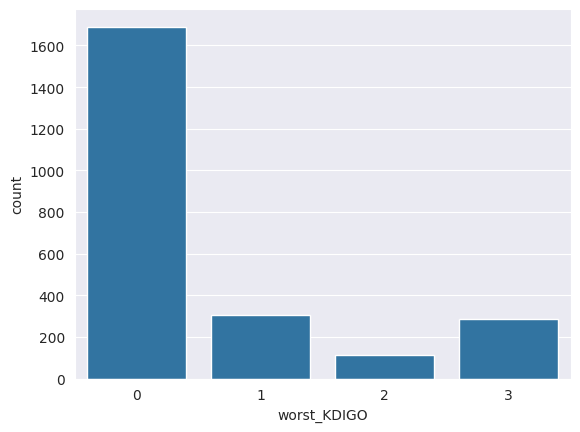

In [213]:
sns.barplot(x=df.worst_KDIGO.value_counts().index, y=df.worst_KDIGO.value_counts())


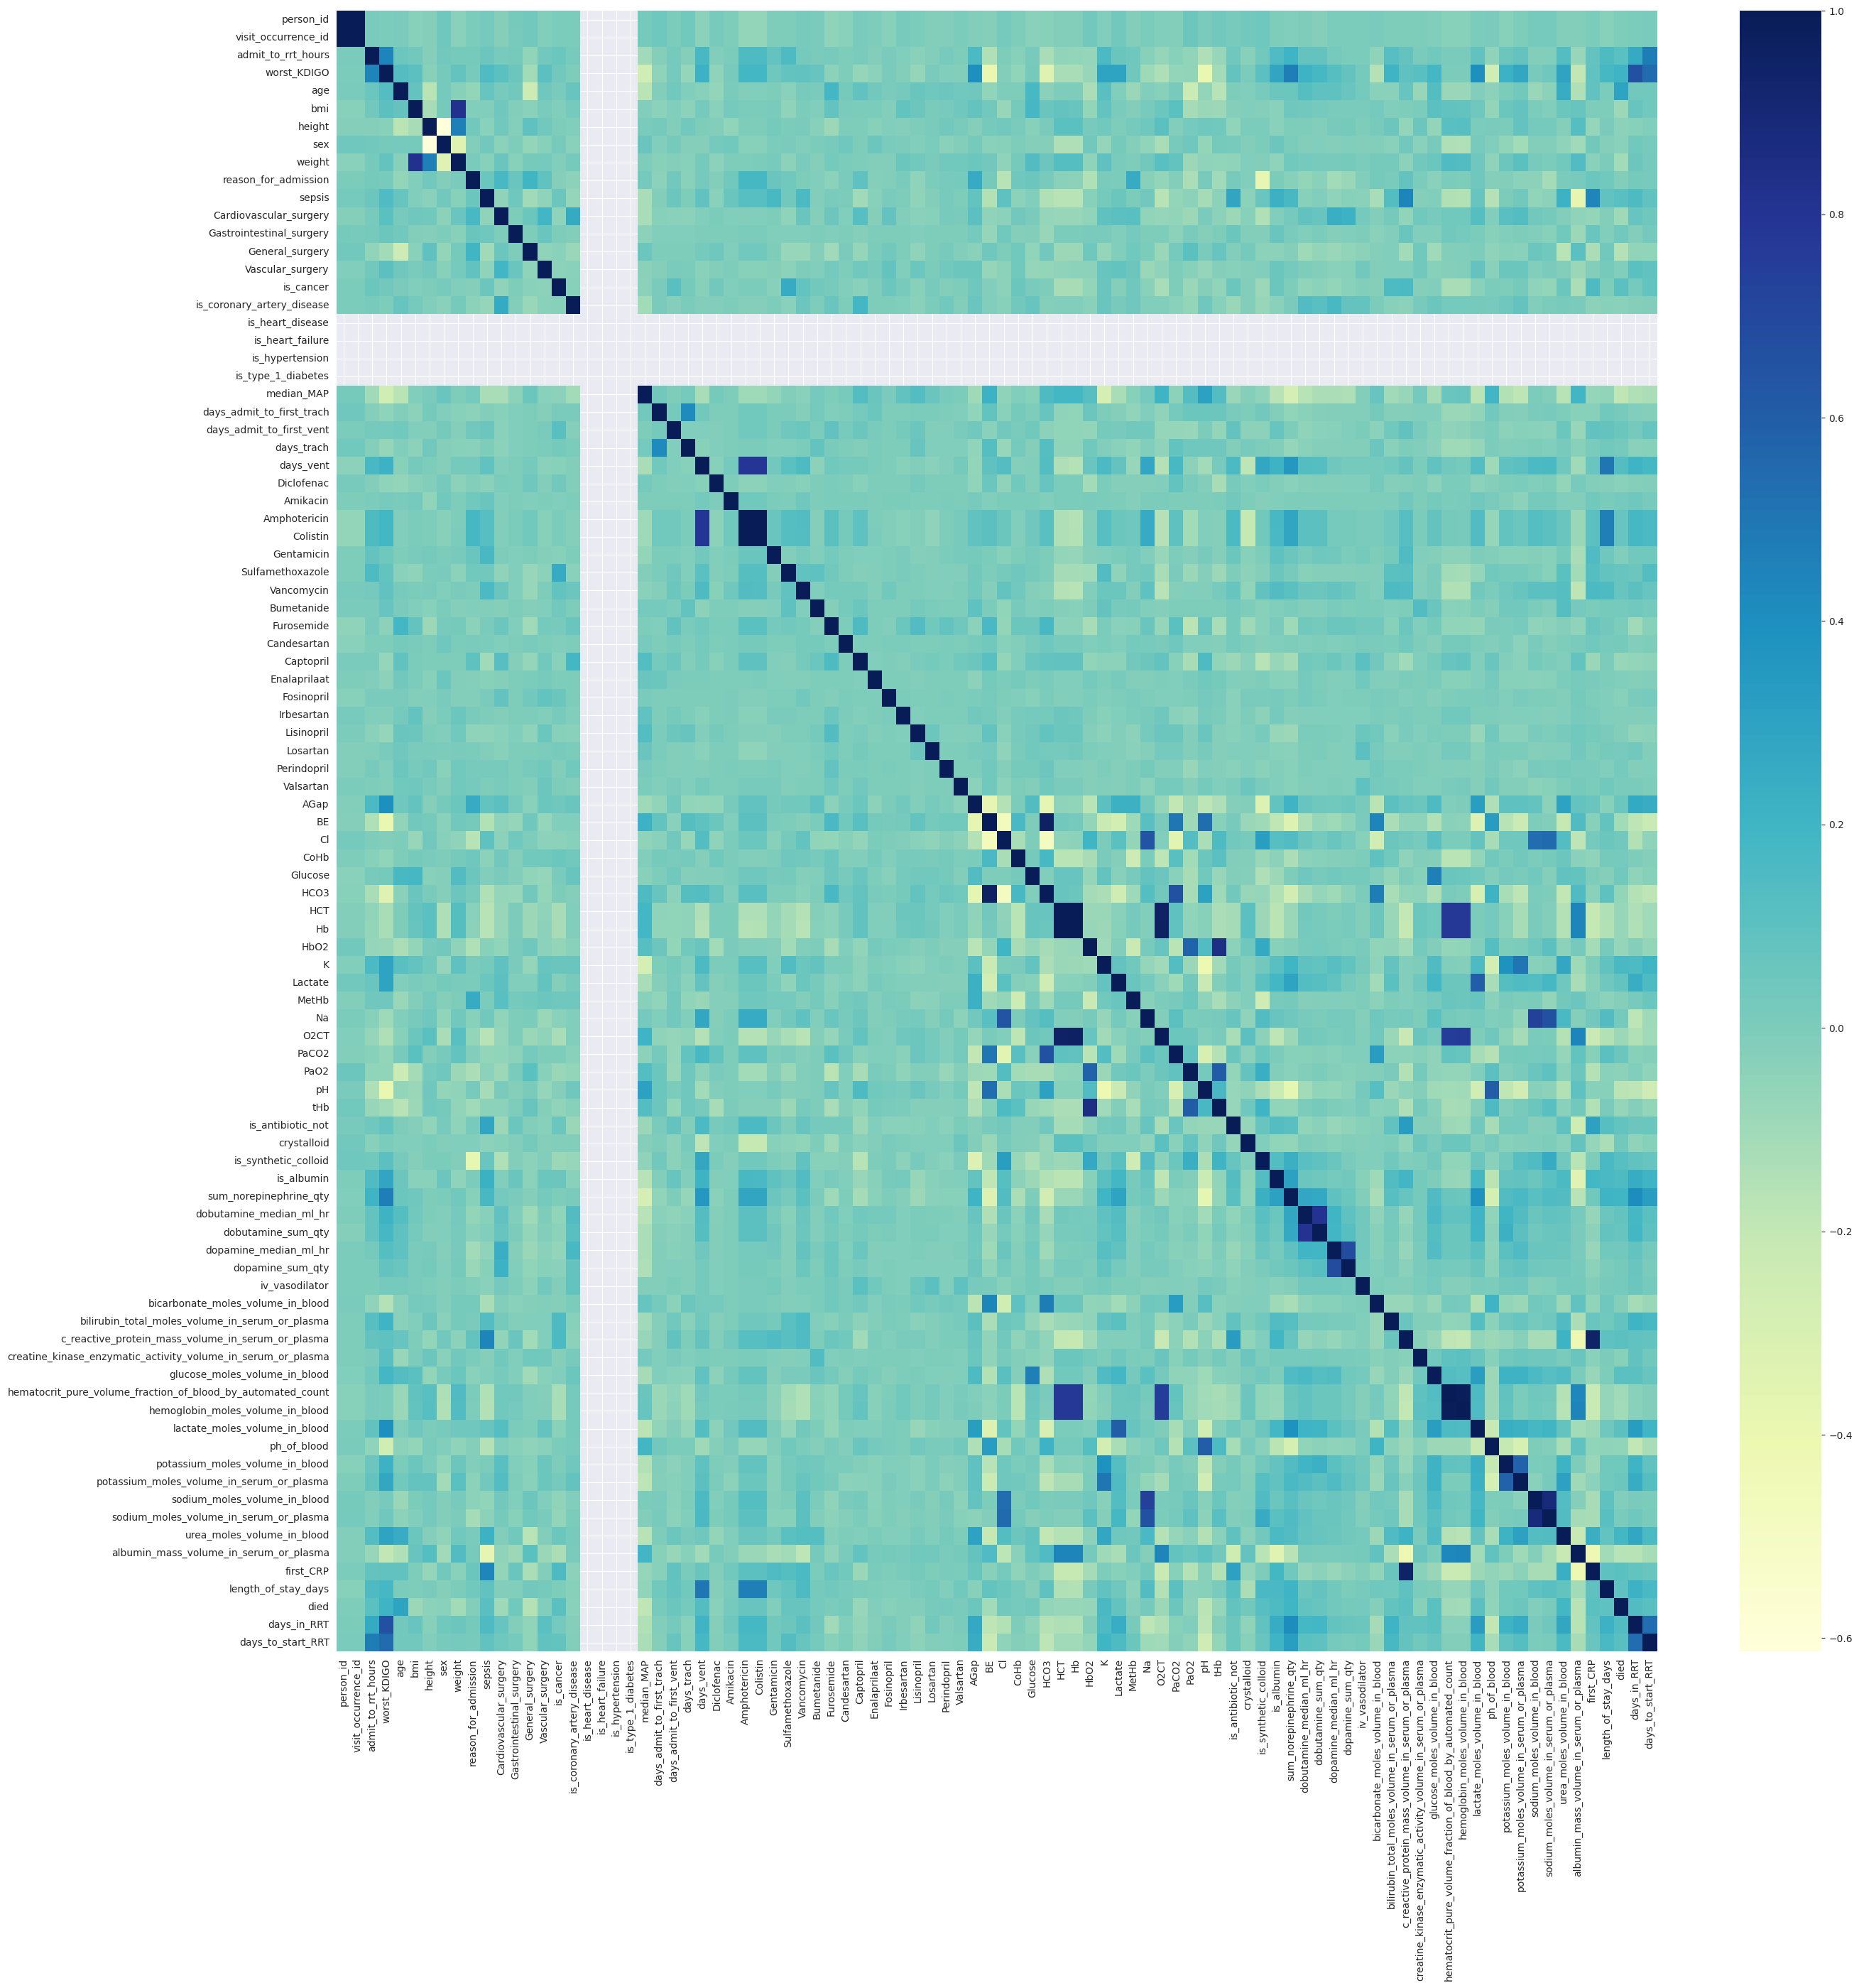

In [109]:
plt.figure(figsize  = (30, 30))
sns.heatmap(df.corr(), annot = False, cmap = "YlGnBu")
plt.show()


## scaling the data

In [110]:
scaler = StandardScaler()

data_scaled = pd.DataFrame(scaler.fit_transform(data_new), columns = data_new.columns)

data_scaled.head()

admit_to_rrt_hours  worst_KDIGO       age       bmi       sex  \
0           -0.188574    -0.566614  0.148137 -0.262255 -0.756613   
1            1.346473     2.353317  0.769066 -0.151928 -0.756613   
2           -0.188574    -0.566614 -0.472792  1.241827 -0.756613   
3           -0.188574     0.406696 -2.025114 -1.490686 -0.756613   
4           -0.188574     1.380007  1.389995 -0.739539 -0.756613   

   reason_for_admission    sepsis  Cardiovascular_surgery  \
0              1.738736 -0.489814                3.262020   
1              1.738736 -0.489814                3.262020   
2              0.263333 -0.489814               -0.306558   
3              0.263333 -0.489814               -0.306558   
4              0.263333 -0.489814               -0.306558   

   Gastrointestinal_surgery  General_surgery  Vascular_surgery  is_cancer  \
0                 -0.084498        -0.418228         -0.194026   -0.30247   
1                 -0.084498        -0.418228         -0.194026   -0.30247   
2                 -0.084498        -0.418228         -0.194026   -0.30247   
3                 -0.084498        -0.418228         -0.194026   -0.30247   
4                 -0.084498        -0.418228         -0.194026   -0.30247   

   is_coronary_artery_disease  is_heart_disease  is_heart_failure  \
0                   -0.201987               0.0               0.0   
1                   -0.201987               0.0               0.0   
2                   -0.201987               0.0               0.0   
3                   -0.201987               0.0               0.0   
4                   -0.201987               0.0               0.0   

   is_hypertension  is_type_1_diabetes  median_MAP  days_admit_to_first_trach  \
0              0.0                 0.0   -0.318550                  -0.134917   
1              0.0                 0.0   -1.639168                  -0.134917   
2              0.0                 0.0    0.624748                  -0.134917   
3              0.0                 0.0    0.153099                  -0.134917   
4              0.0                 0.0    0.058769                   1.477827   

   days_admit_to_first_vent  days_trach  days_vent  Diclofenac  Amikacin  \
0                  1.147253   -0.143592   1.137794   -0.084952 -0.031081   
1                  0.019655   -0.143592   0.038359   -0.084952 -0.031081   
2                  0.320348   -0.143592   1.137794   -0.084952 -0.031081   
3                 -0.205864   -0.143592   1.137794   -0.084952 -0.031081   
4                 -0.281037    2.917160  -1.427553   -0.084952 -0.031081   

   Amphotericin  Colistin  Gentamicin  Sulfamethoxazole  Vancomycin  \
0      0.675555  0.677828   -0.169397         -0.235171   -0.343807   
1     -0.401560 -0.399330   -0.169397         -0.235171    0.933417   
2      0.675555  0.677828   -0.169397         -0.235171   -0.343807   
3      1.034593  1.036881   -0.169397         -0.235171   -0.343807   
4     -1.478674 -1.476489   -0.169397         -0.235171   -0.343807   

   Bumetanide  Furosemide  Candesartan  Captopril  Enalaprilaat  Fosinopril  \
0   -0.074569    1.792362    -0.033465   4.246972     -0.081995   -0.033366   
1   -0.074569   -0.726539    -0.033465  -0.371730     -0.081995   -0.033366   
2   -0.074569    1.792362    -0.033465  -0.371730     -0.081995   -0.033366   
3   -0.074569   -0.726539    -0.033465  -0.371730     -0.081995   -0.033366   
4   -0.074569    0.113095    -0.033465  -0.371730     -0.081995   -0.033366   

   Irbesartan  Lisinopril  Losartan  Perindopril  Valsartan      AGap  \
0   -0.054599   -0.217944 -0.089622    -0.059351  -0.075573  0.679457   
1   -0.054599   -0.217944 -0.089622    -0.059351  -0.075573  0.679457   
2   -0.054599    5.240333 -0.089622    -0.059351  -0.075573  0.318936   
3   -0.054599   -0.217944 -0.089622    -0.059351  -0.075573  0.318936   
4   -0.054599   -0.217944 -0.089622    -0.059351  -0.075573  0.679457   

         BE        Cl      CoHb   Glucose      HCO3       HCT   

## PCA

In [111]:
# Defining the number of principal components to generate
n = data_scaled.shape[1]

# Finding principal components for the data
pca = PCA(n_components = n, random_state = 1)

data_pca1 = pd.DataFrame(pca.fit_transform(data_scaled))

# The percentage of variance explained by each principal component
exp_var = pca.explained_variance_ratio_


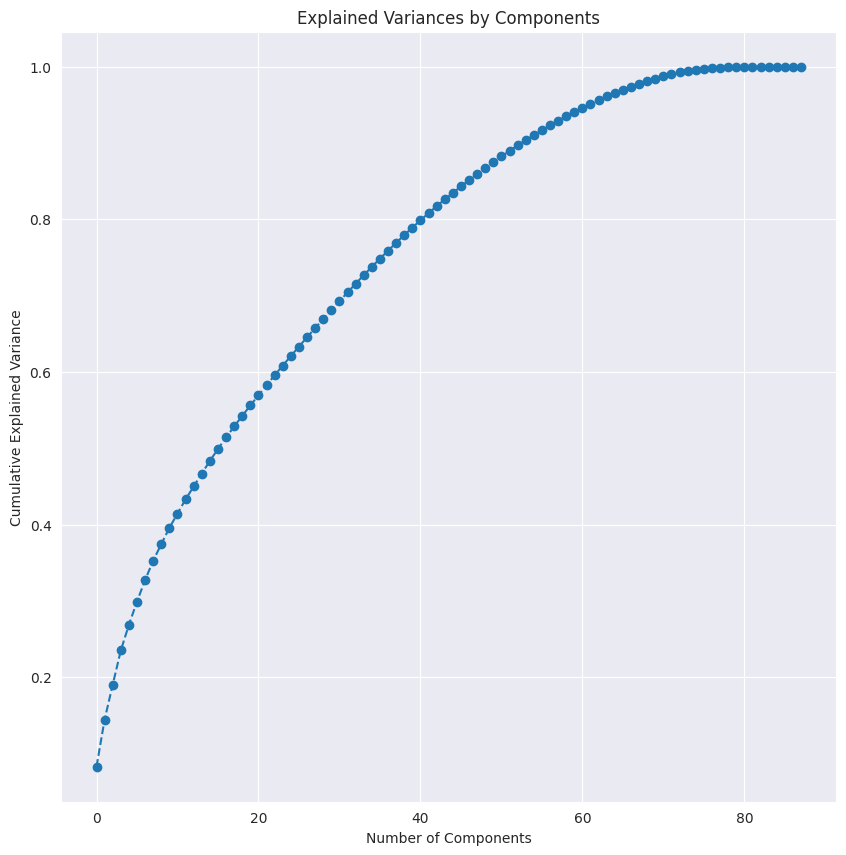

In [112]:
# Plotting the explained cumulative variance by principal components
plt.figure(figsize = (10, 10))
plt.plot(pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()


In [113]:
# Finding the least number of components that can explain more than 70% variance
sum = 0
for ix, i in enumerate(exp_var):
    sum = sum + i
    if(sum>0.70):
        print("Number of components that explain at least 70% variance:", ix + 1)
        break

Number of components that explain at least 70% variance: 32


In [114]:
pc_comps = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'
           ,'PC11', 'PC12', 'PC13', 'PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20'
           ]

data_pca = pd.DataFrame(np.round(pca.components_[:20,:],2), index = pc_comps, columns = data_scaled.columns)

data_pca

admit_to_rrt_hours  worst_KDIGO   age   bmi   sex  reason_for_admission  \
PC1                 0.13         0.26  0.06  0.01  0.02                  0.01   
PC2                 0.05         0.13  0.01  0.06 -0.06                 -0.02   
PC3                 0.02         0.07  0.06  0.00  0.04                  0.05   
PC4                 0.09         0.06  0.09  0.09 -0.03                  0.14   
PC5                 0.00         0.06  0.00  0.04  0.00                 -0.02   
PC6                -0.11        -0.11  0.21  0.06 -0.03                  0.00   
PC7                 0.05         0.02 -0.20 -0.05  0.01                  0.36   
PC8                -0.04         0.01 -0.17  0.02 -0.00                  0.08   
PC9                 0.21         0.18  0.14  0.09  0.03                 -0.08   
PC10                0.11         0.14 -0.02 -0.04  0.11                 -0.06   
PC11               -0.11        -0.06  0.17  0.08  0.19                  0.00   
PC12                0.20         0.01  0.08 -0.16 -0.01                 -0.17   
PC13               -0.02        -0.06 -0.14 -0.19 -0.06                  0.06   
PC14                0.02        -0.04 -0.12  0.11 -0.07                  0.01   
PC15                0.08         0.07  0.01  0.21  0.22                 -0.04   
PC16               -0.13        -0.03 -0.23  0.06  0.07                 -0.21   
PC17                0.12         0.05 -0.11  0.14  0.26                 -0.08   
PC18                0.17         0.09 -0.01  0.16 -0.24                  0.02   
PC19               -0.19         0.01  0.01 -0.28 -0.16                  0.03   
PC20               -0.18        -0.05  0.10  0.04 -0.01                  0.20   

      sepsis  Cardiovascular_surgery  Gastrointestinal_surgery  \
PC1     0.14                    0.04                      0.02   
PC2    -0.08                    0.05                      0.00   
PC3     0.05                    0.05                      0.03   
PC4     0.03                    0.03                     -0.00   
PC5    -0.25                    0.19                     -0.07   
PC6    -0.05                    0.15                     -0.02   
PC7    -0.07                    0.15                      0.01   
PC8    -0.09                   -0.04                     -0.02   
PC9    -0.09                   -0.23                     -0.05   
PC10   -0.02                    0.10                     -0.02   
PC11   -0.03                   -0.23                      0.01   
PC12   -0.22                   -0.10                     -0.03   
PC13    0.01                   -0.14                     -0.06   
PC14   -0.01                   -0.01                     -0.04   
PC15    0.02                   -0.07                     -0.08   
PC16    0.01                   -0.05                     -0.21   
PC17   -0.05                   -0.10                     -0.06   
PC18    0.05                    0.03                      0.02   
PC19   -0.01                   -0.16                     -0.01   
PC20    0.04                   -0.06                      0.02   

      General_surgery  Vascular_surgery  is_cancer  \
PC1             -0.04              0.03       0.05   
PC2             -0.03              0.01      -0.08   
PC3             -0.04              0.06       0.07   
PC4             -0.05              0.01       0.05   
PC5              0.05              0.06      -0.06   
PC6             -0.11             -0.00       0.01   
PC7              0.21              0.06      -0.02   
PC8              0.22              0.07       0.04   
PC9             -0.19             -0.02       0.15   
PC10            -0.02              0.12      -0.04   
PC11             0.04             -0.05      -0.14   
PC12            -0.03             -0.04       0.15   
PC13             0.07             -0.37       0.22   
PC14             0.04             -0.03       0.13   
PC15             0.02             -0.26      -0.01   
PC16             0.05             -0.16       0.17   

In [115]:
def color_high(val):
    if val < -0.25:                     # what should i put as cut off here?
        return 'background: pink'
    elif val > 0.25:
        return 'background: skyblue'

data_pca.T.style.applymap(color_high)

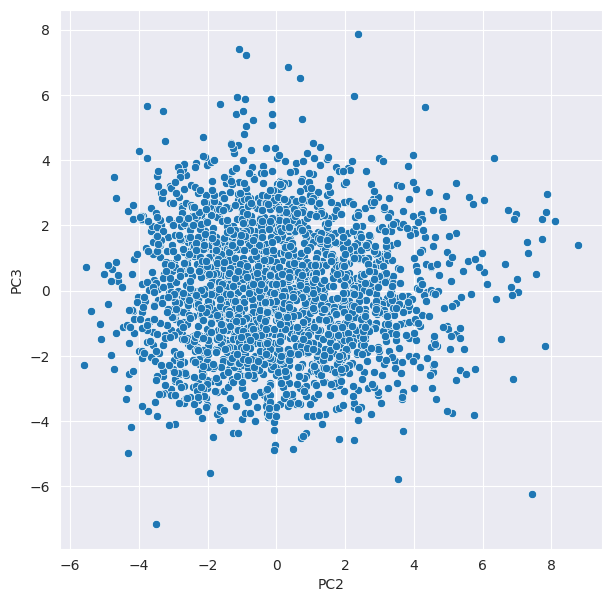

In [116]:
# unfortunately after trying a few, unable to see any patterns

fig = plt.figure(figsize = (7,7))

sns.scatterplot(x = data_pca1[1], y = data_pca1[2])

plt.xlabel("PC2")
plt.ylabel("PC3")

plt.show()


## Reduce features, based on the PCA

In [117]:
# kept most of the original from Ryu, exceptions are marked #
y_cols = [ 'admit_to_rrt_hours', 'worst_KDIGO']

cols = [ 'age', 'bmi', 'sex', 'reason_for_admission'
, 'Gastrointestinal_surgery', 'Vascular_surgery'
, 'days_admit_to_first_trach', 'days_trach', 'days_vent'
, 'Amphotericin', 'Colistin', 'Sulfamethoxazole', 'Bumetanide', 'Furosemide', 'Irbesartan', 'Lisinopril', 'Losartan', 'Valsartan'
, 'AGap', 'Cl', 'CoHb', 'Glucose', 'HCT', 'Hb', 'HbO2', 'K', 'Lactate', 'MetHb', 'Na', 'O2CT', 'PaCO2', 'PaO2', 'pH', 'tHb'  # messing around by me
, 'is_synthetic_colloid', 'dobutamine_median_ml_hr',  'dopamine_median_ml_hr' # messing around by me
, 'dobutamine_sum_qty', 'dopamine_sum_qty', 'iv_vasodilator', 'bilirubin_total_moles_volume_in_serum_or_plasma'
, 'c_reactive_protein_mass_volume_in_serum_or_plasma', 'glucose_moles_volume_in_blood'
, 'hematocrit_pure_volume_fraction_of_blood_by_automated_count', 'hemoglobin_moles_volume_in_blood'
, 'potassium_moles_volume_in_serum_or_plasma', 'sodium_moles_volume_in_blood', 'sodium_moles_volume_in_serum_or_plasma'
, 'urea_moles_volume_in_blood', 'first_CRP', 'died', 'days_in_RRT'
      ]

data_y = data_scaled[y_cols]

data_scaled = data_scaled[cols]


## K-Means Clustering

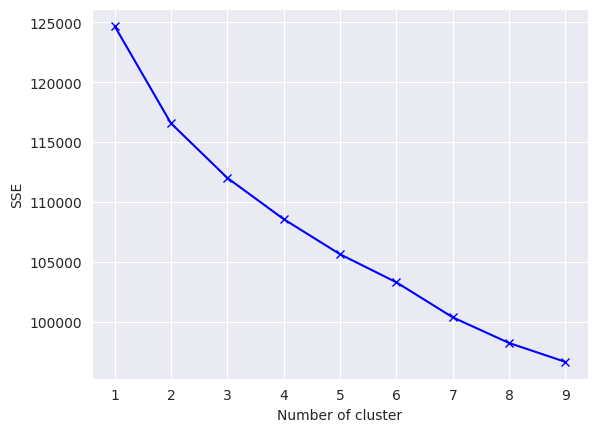

In [118]:
# Empty dictionary to store the SSE for each value of K
sse = {}

# Iterate for a range of Ks and fit the scaled data to the algorithm.
# Use inertia attribute from the clustering object and store the inertia value for that K
for k in range(1, 10):
    kmeans = KMeans(n_clusters = k, random_state = 1).fit(data_scaled)
    sse[k] = kmeans.inertia_

# Elbow plot
plt.figure()

plt.plot(list(sse.keys()), list(sse.values()), 'bx-')

plt.xlabel("Number of cluster")

plt.ylabel("SSE")

plt.show()

there is no elbow, so look at silhouette score

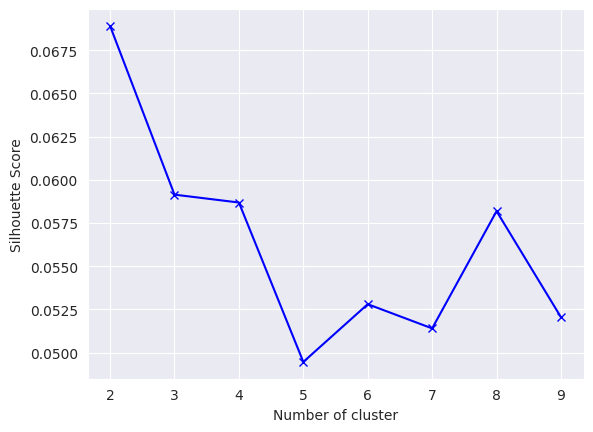

In [119]:
# Empty dictionary to store the Silhouette score for each value of K
sc = {}

# Iterate for a range of Ks and fit the scaled data to the algorithm. Store the Silhouette score for that K
for k in range(2, 10):
    kmeans = KMeans(n_clusters = k, random_state = 1).fit(data_scaled)
    labels = kmeans.predict(data_scaled)
    sc[k] = silhouette_score(data_scaled, labels)

# Elbow plot
plt.figure()

plt.plot(list(sc.keys()), list(sc.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette Score")

plt.show()


### try Kmeans n_cluster 3

In [120]:
# use clusters 3
kmeans = KMeans(n_clusters = 3, random_state = 1)
kmeans.fit(data_scaled)

# Adding predicted labels to the original data and the scaled data
data_new['KMeans_Labels'] = kmeans.predict(data_scaled)

In [121]:
data_new['KMeans_Labels'].value_counts()

KMeans_Labels
2    924
0    756
1    718
Name: count, dtype: int64

In [122]:
# Calculating the mean and the median of the original data for each label
mean = data_new.groupby('KMeans_Labels').mean()
median = data_new.groupby('KMeans_Labels').median()

df_kmeans = pd.concat([mean, median], axis = 0)
df_kmeans.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_0 Median', 'group_1 Median', 'group_2 Median']

df_kmeans[cols]


age        bmi       sex  reason_for_admission  \
group_0 Mean    74.415344  25.226552  1.448413              0.728836   
group_1 Mean    71.458217  26.202831  1.238162              0.842618   
group_2 Mean    74.634199  25.601955  1.395022              0.880952   
group_0 Median       76.0  24.489796       1.0                   1.0   
group_1 Median       76.0  24.835646       1.0                   1.0   
group_2 Median       76.0  24.594362       1.0                   1.0   

                Gastrointestinal_surgery  Vascular_surgery  \
group_0 Mean                    0.006614          0.043651   
group_1 Mean                    0.006964          0.018106   
group_2 Mean                    0.007576          0.044372   
group_0 Median                       0.0               0.0   
group_1 Median                       0.0               0.0   
group_2 Median                       0.0               0.0   

                days_admit_to_first_trach  days_trach  days_vent  \
group_0 Mean                     0.087026    0.136243   1.570106   
group_1 Mean                     0.053737    0.037604   3.614206   
group_2 Mean                     0.095103    0.102814   6.016234   
group_0 Median                   0.000000         0.0        1.0   
group_1 Median                   0.000000         0.0        3.0   
group_2 Median                   0.000000         0.0        7.0   

                Amphotericin  Colistin  Sulfamethoxazole  Bumetanide  \
group_0 Mean        1.703704  1.701058          0.161376    0.030423   
group_1 Mean        3.917827  3.915042          0.108635    0.008357   
group_2 Mean            6.25  6.238095          0.508658    0.016234   
group_0 Median           1.0       1.0               0.0         0.0   
group_1 Median           4.0       4.0               0.0         0.0   
group_2 Median           7.0       7.0               0.0         0.0   

                Furosemide  Irbesartan  Lisinopril  Losartan  Valsartan  \
group_0 Mean      0.804233    0.007937    0.156085  0.048942   0.026455   
group_1 Mean      0.803621    0.019499    0.182451  0.036212    0.02507   
group_2 Mean      0.963203    0.008658    0.145022  0.005411   0.014069   
group_0 Median         0.0         0.0         0.0       0.0        0.0   
group_1 Median         0.0         0.0         0.0       0.0        0.0   
group_2 Median         1.0         0.0         0.0       0.0        0.0   

                    AGap          Cl      CoHb   Glucose       HCT        Hb  \
group_0 Mean    7.724868  105.260582  1.118915  7.511376  0.302169  6.094577   
group_1 Mean    8.129526  106.150418  0.950000  7.845682  0.384735  7.768245   
group_2 Mean    8.423810  108.069264  1.110714  7.653571  0.295195  5.918074   
group_0 Median  8.000000  106.000000  1.100000  7.400000  0.300000  6.100000   
group_1 Median  8.000000  106.000000  0.900000  7.700000  0.380000  7.700000   
group_2 Median  8.000000  108.000000  1.100000  7.600000  0.290000  5.900000   

                    HbO2         K   Lactate     MetHb          Na       O2CT  \
group_0 Mean    0.954087  3.978439  1.391799  0.862302  137.181217  13.314815   
group_1 Mean    0.950446  4.023955  1.559610  0.899025  139.626741  16.874652   
group_2 Mean    0.951126  4.124026  1.845779  0.852273  141.195887  12.877706   
group_0 Median  0.960000  3.900000  1.300000  0.900000  137.000000  13.000000   
group_1 Median  0.950000  4.000000  1.300000  0.900000  140.000000  17.000000   
group_2 Median  0.950000  4.100000  1.300000  0.850000  141.000000  13.000000   

                    PaCO2       PaO2        pH       tHb  \
group_0 Mean    38.692857  96.409524  7.410317  0.974246   
group_1 Mean    41.962117  91.286072  7.392799  0.968983   
group_2 Mean    41.377056  90.569264  7.385628  0.971071   
group_0 Median  38.000000  93.000000  7.420000  0.980000   
group_1 Median  40.000000  89.000000  7.400000  0.970000   
group_2 Median  41.000000  89.000000  7.400000  0.970000   

                is_synth

### try Kmeans n_cluster 4


In [123]:
# use clusters 4
kmeans = KMeans(n_clusters = 4, random_state = 1)
kmeans.fit(data_scaled)

# Adding predicted labels to the original data and the scaled data
data_new['KMeans_Labels'] = kmeans.predict(data_scaled)

In [124]:
data_new['KMeans_Labels'].value_counts()

KMeans_Labels
3    886
0    704
1    646
2    162
Name: count, dtype: int64

In [125]:
# Calculating the mean and the median of the original data for each label
mean = data_new.groupby('KMeans_Labels').mean()
median = data_new.groupby('KMeans_Labels').median()

df_kmeans = pd.concat([mean, median], axis = 0)
df_kmeans.index = ['group_0 Mean', 'group_1 Mean', 'group_2 Mean', 'group_3 Mean'
                , 'group_0 Median', 'group_1 Median', 'group_2 Median', 'group_3 Median']

df_kmeans[cols]

age        bmi       sex  reason_for_admission  \
group_0 Mean    74.173295  25.249358  1.446023              0.684659   
group_1 Mean    70.922601  26.201261  1.239938              0.896285   
group_2 Mean    80.635802  25.721867  1.333333              0.549383   
group_3 Mean    73.848758  25.589850  1.397291              0.925508   
group_0 Median       76.0  24.489796       1.0                   1.0   
group_1 Median       76.0  24.835646       1.0                   1.0   
group_2 Median       86.0  24.835646       1.0                   0.0   
group_3 Median       76.0  24.489796       1.0                   1.0   

                Gastrointestinal_surgery  Vascular_surgery  \
group_0 Mean                    0.005682          0.048295   
group_1 Mean                     0.00774          0.018576   
group_2 Mean                    0.006173          0.037037   
group_3 Mean                    0.007901          0.039503   
group_0 Median                       0.0               0.0   
group_1 Median                       0.0               0.0   
group_2 Median                       0.0               0.0   
group_3 Median                       0.0               0.0   

                days_admit_to_first_trach  days_trach  days_vent  \
group_0 Mean                     0.068774    0.122159   1.491477   
group_1 Mean                     0.049536    0.040248   3.509288   
group_2 Mean                     0.000000         0.0   5.216049   
group_3 Mean                     0.126223     0.12754   5.845372   
group_0 Median                   0.000000         0.0        1.0   
group_1 Median                   0.000000         0.0        3.0   
group_2 Median                   0.000000         0.0        7.0   
group_3 Median                   0.000000         0.0        7.0   

                Amphotericin  Colistin  Sulfamethoxazole  Bumetanide  \
group_0 Mean         1.40483  1.401989           0.15767    0.025568   
group_1 Mean        3.845201  3.842105          0.119195    0.012384   
group_2 Mean        5.179012  5.166667          0.111111    0.018519   
group_3 Mean         6.27991  6.269752          0.523702     0.01693   
group_0 Median           0.0       0.0               0.0         0.0   
group_1 Median           4.0       4.0               0.0         0.0   
group_2 Median           6.0       6.0               0.0         0.0   
group_3 Median           7.0       7.0               0.0         0.0   

                Furosemide  Irbesartan  Lisinopril  Losartan  Valsartan  \
group_0 Mean      0.796875    0.008523    0.153409  0.056818   0.028409   
group_1 Mean       0.74613    0.021672    0.178019  0.032508   0.026316   
group_2 Mean       1.04321         0.0    0.154321  0.012346   0.006173   
group_3 Mean      0.974041    0.009029     0.15237  0.005643   0.014673   
group_0 Median         0.0         0.0         0.0       0.0        0.0   
group_1 Median         0.0         0.0         0.0       0.0        0.0   
group_2 Median         1.0         0.0         0.0       0.0        0.0   
group_3 Median         1.0         0.0         0.0       0.0        0.0   

                    AGap          Cl      CoHb   Glucose       HCT        Hb  \
group_0 Mean    7.579545  105.568182  1.107528  7.461932  0.303523  6.125994   
group_1 Mean    8.128483  105.829721  0.962074  7.826935  0.387972  7.831269   
group_2 Mean    8.938272  109.086420  0.953704  7.902469  0.325679  6.558025   
group_3 Mean    8.381038  107.551919  1.127088  7.668284  0.293871  5.890858   
group_0 Median  7.000000  106.000000  1.000000  7.400000  0.300000  6.100000   
group_1 Median  8.000000  106.000000  0.900000  7.700000  0.380000  7.750000   
group_2 Median  9.000000  109.000000  0.900000  7.700000  0.320000  6.500000   
group_3 Median  8.000000  107.000000  1.100000  7.600000  0.290000  5.900000   

                    HbO2         K   Lactate     MetHb          Na       O2CT  \
group_0 Mean    0.955298  3.973864  1.361222  0.856960  137.325284  13.407

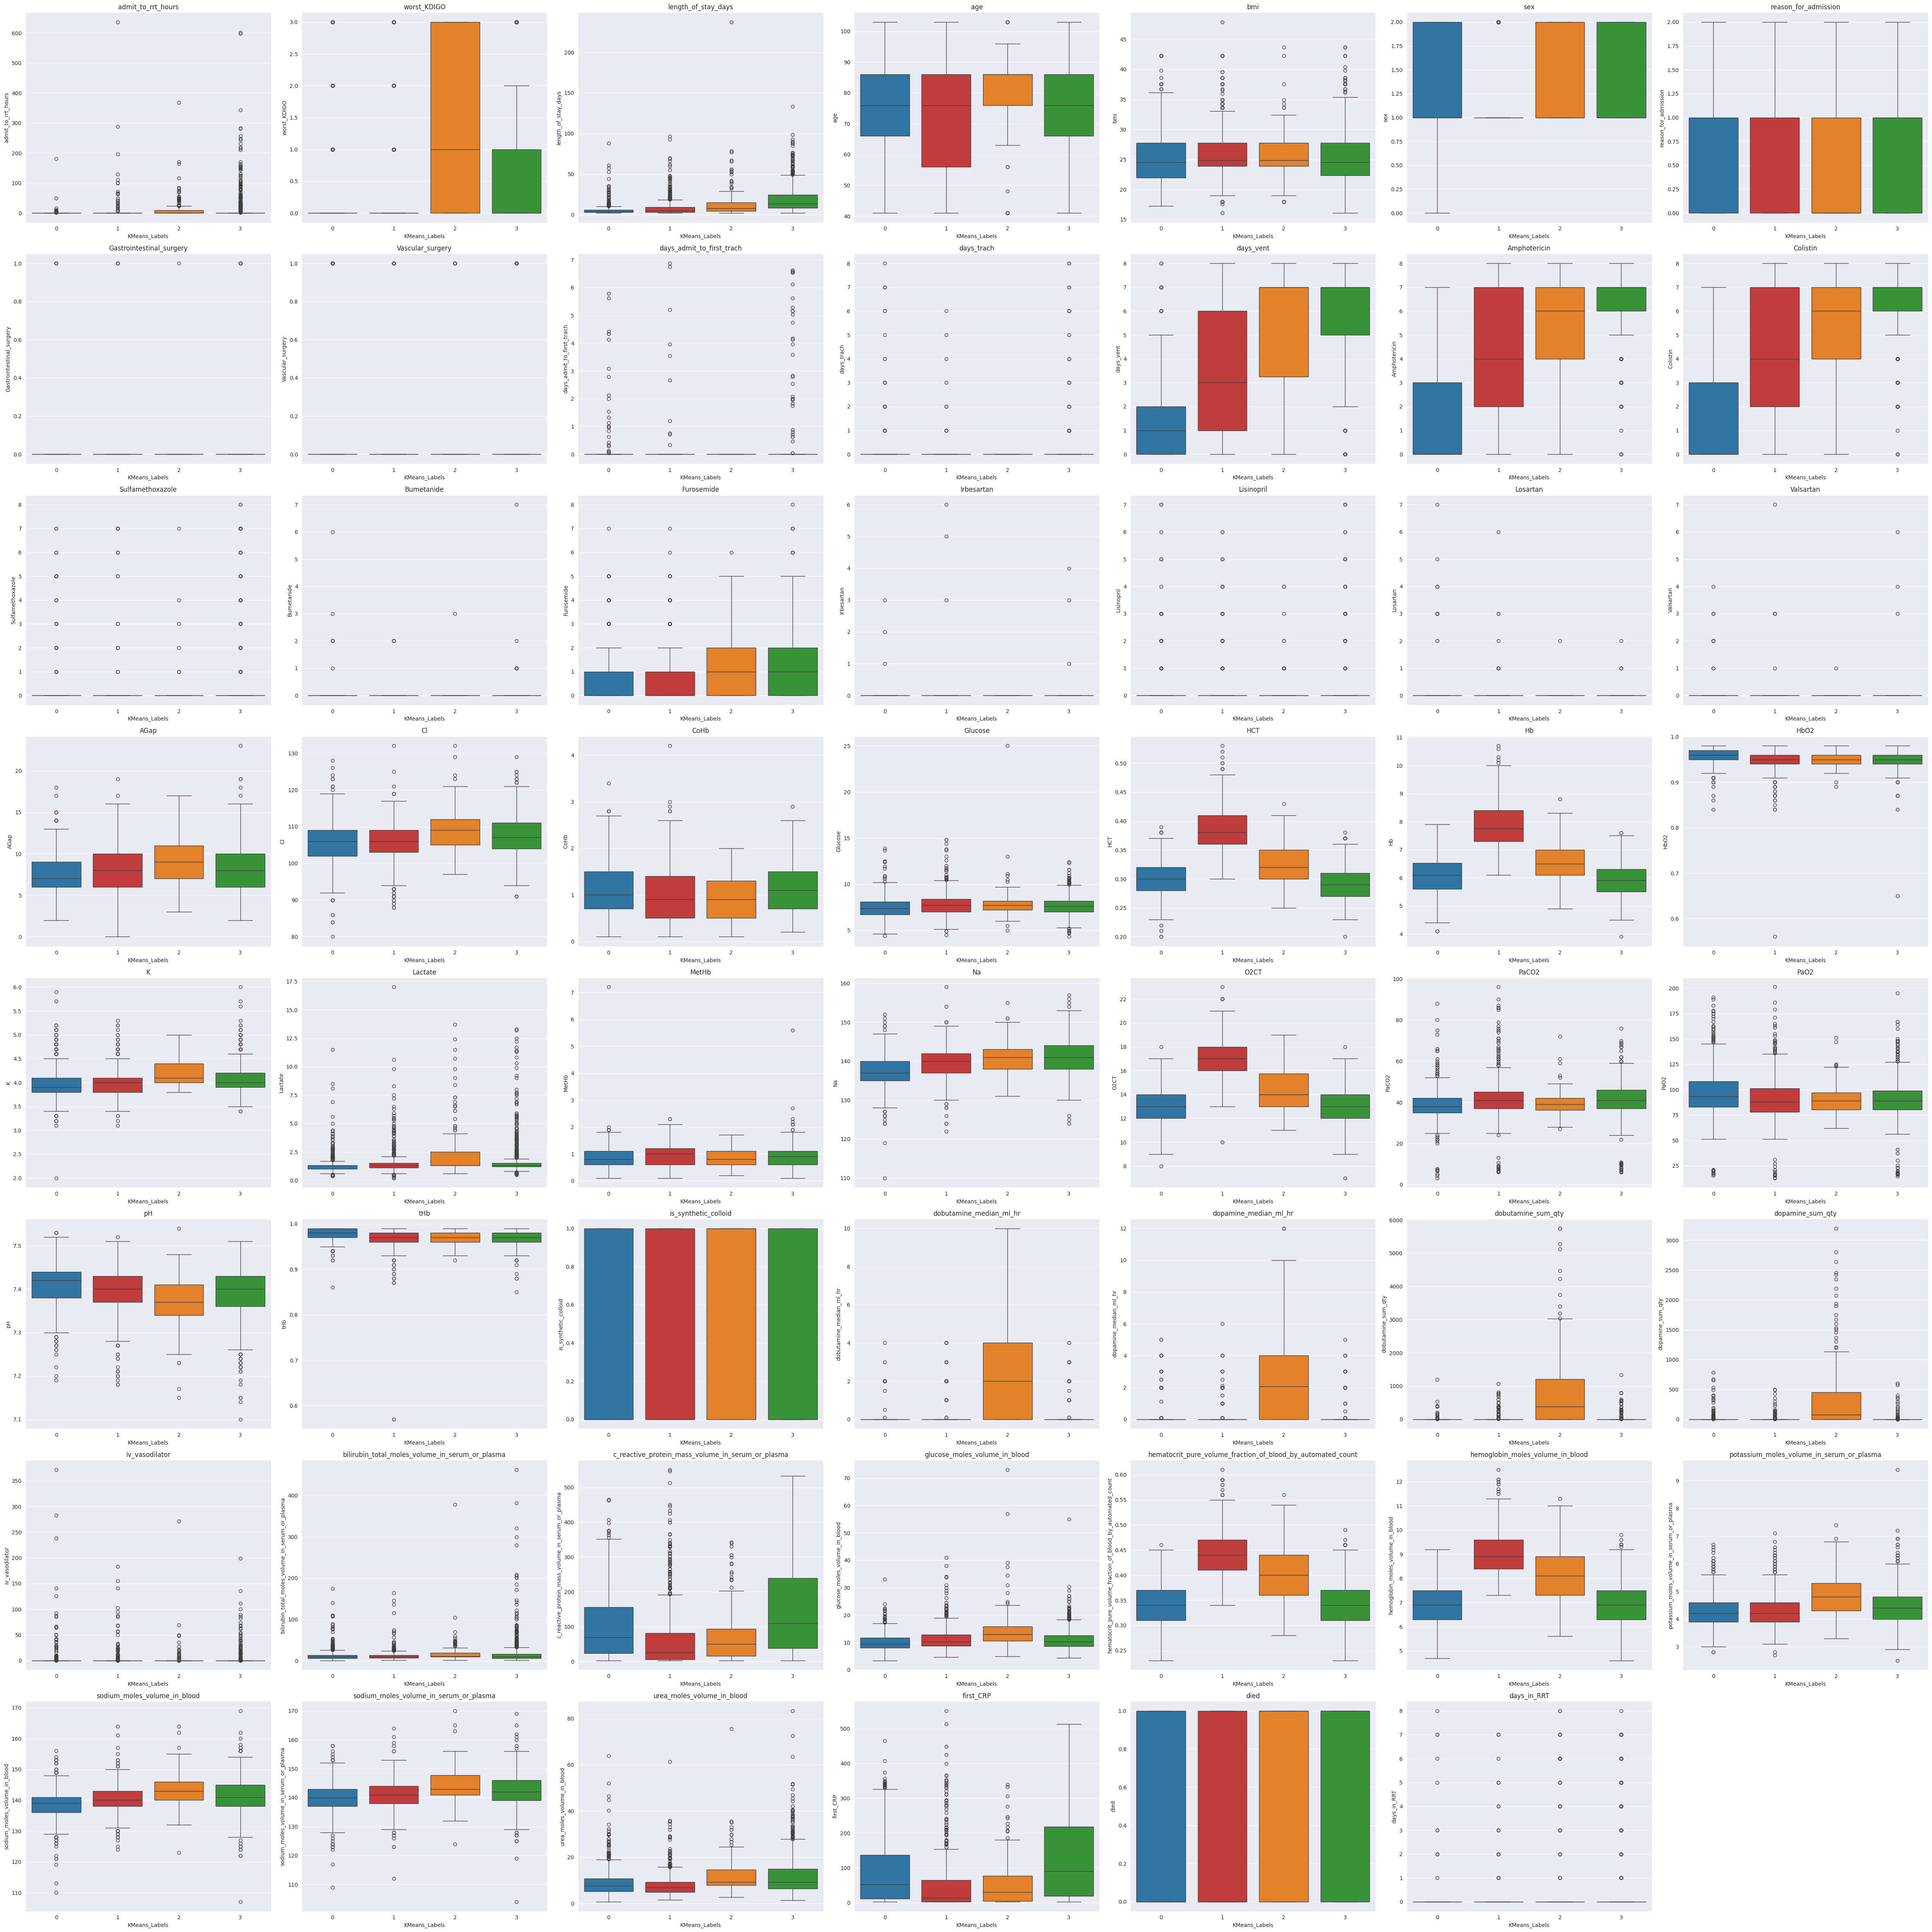

In [195]:
cols = [ 'admit_to_rrt_hours', 'worst_KDIGO', 'length_of_stay_days' ,'age', 'bmi', 'sex', 'reason_for_admission'
        , 'Gastrointestinal_surgery', 'Vascular_surgery', 'days_admit_to_first_trach', 'days_trach', 'days_vent'
        , 'Amphotericin', 'Colistin', 'Sulfamethoxazole', 'Bumetanide', 'Furosemide', 'Irbesartan', 'Lisinopril', 'Losartan', 'Valsartan'
        , 'AGap', 'Cl', 'CoHb', 'Glucose', 'HCT', 'Hb', 'HbO2', 'K', 'Lactate', 'MetHb', 'Na', 'O2CT', 'PaCO2', 'PaO2', 'pH', 'tHb'  # messing around by me
        , 'is_synthetic_colloid', 'dobutamine_median_ml_hr',  'dopamine_median_ml_hr' # messing around by me
        , 'dobutamine_sum_qty', 'dopamine_sum_qty', 'iv_vasodilator', 'bilirubin_total_moles_volume_in_serum_or_plasma'
        , 'c_reactive_protein_mass_volume_in_serum_or_plasma', 'glucose_moles_volume_in_blood'
        , 'hematocrit_pure_volume_fraction_of_blood_by_automated_count', 'hemoglobin_moles_volume_in_blood'
        , 'potassium_moles_volume_in_serum_or_plasma', 'sodium_moles_volume_in_blood', 'sodium_moles_volume_in_serum_or_plasma'
        , 'urea_moles_volume_in_blood', 'first_CRP', 'died', 'days_in_RRT'
      ]

palette ={1: "C3", 2: "C1", 3: "C2", 0: "C0"}

plt.figure(figsize = (50, 50))

for i, variable in enumerate(cols):
    plt.subplot(8, 7, i + 1)
    sns.boxplot(y=data_new[variable], x=data_new['KMeans_Labels'], hue=data_new['KMeans_Labels'], palette = palette)
    plt.legend([], [], frameon=False)
    plt.tight_layout()
    plt.title(variable)

plt.show()


### KMeans does not align to KDIGO, why?



In [187]:
data_new.groupby([ 'worst_KDIGO', 'KMeans_Labels', 'died']).size()

worst_KDIGO  KMeans_Labels  died
0            0              0       353
                            1       223
             1              0       366
                            1       154
             2              0        37
                            1        21
             3              0       296
                            1       240
1            0              0        50
                            1        24
             1              0        30
                            1        28
             2              0        19
                            1        14
             3              0        62
                            1        79
2            0              0        11
                            1        22
             1              0        12
                            1        13
             2              0         9
                            1         9
             3              0        16
                            1        24
3      

<Axes: xlabel='KMeans_Labels', ylabel='died'>

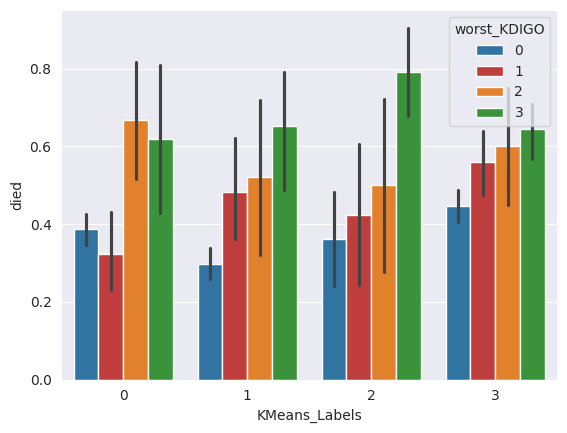

In [192]:

sns.barplot(y=data_new['died'], x=data_new['KMeans_Labels'], hue=data_new['worst_KDIGO'], palette = palette)


<Axes: xlabel='KMeans_Labels', ylabel='admit_to_rrt_hours'>

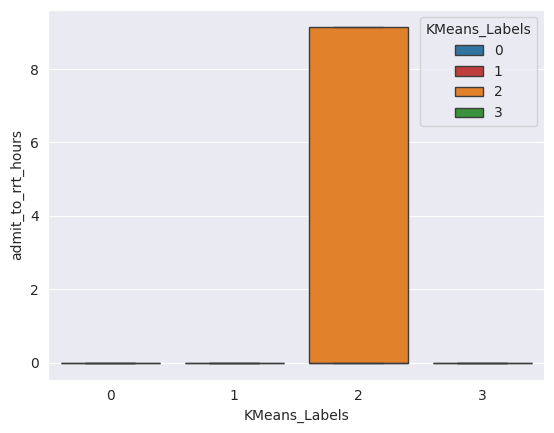

In [194]:
sns.boxplot(y=data_new['admit_to_rrt_hours'], x=data_new['KMeans_Labels'], hue=data_new['KMeans_Labels'], palette = palette
            , showfliers=False, whis=0)


### Plot without the outlier bubbles, whiskers and legend



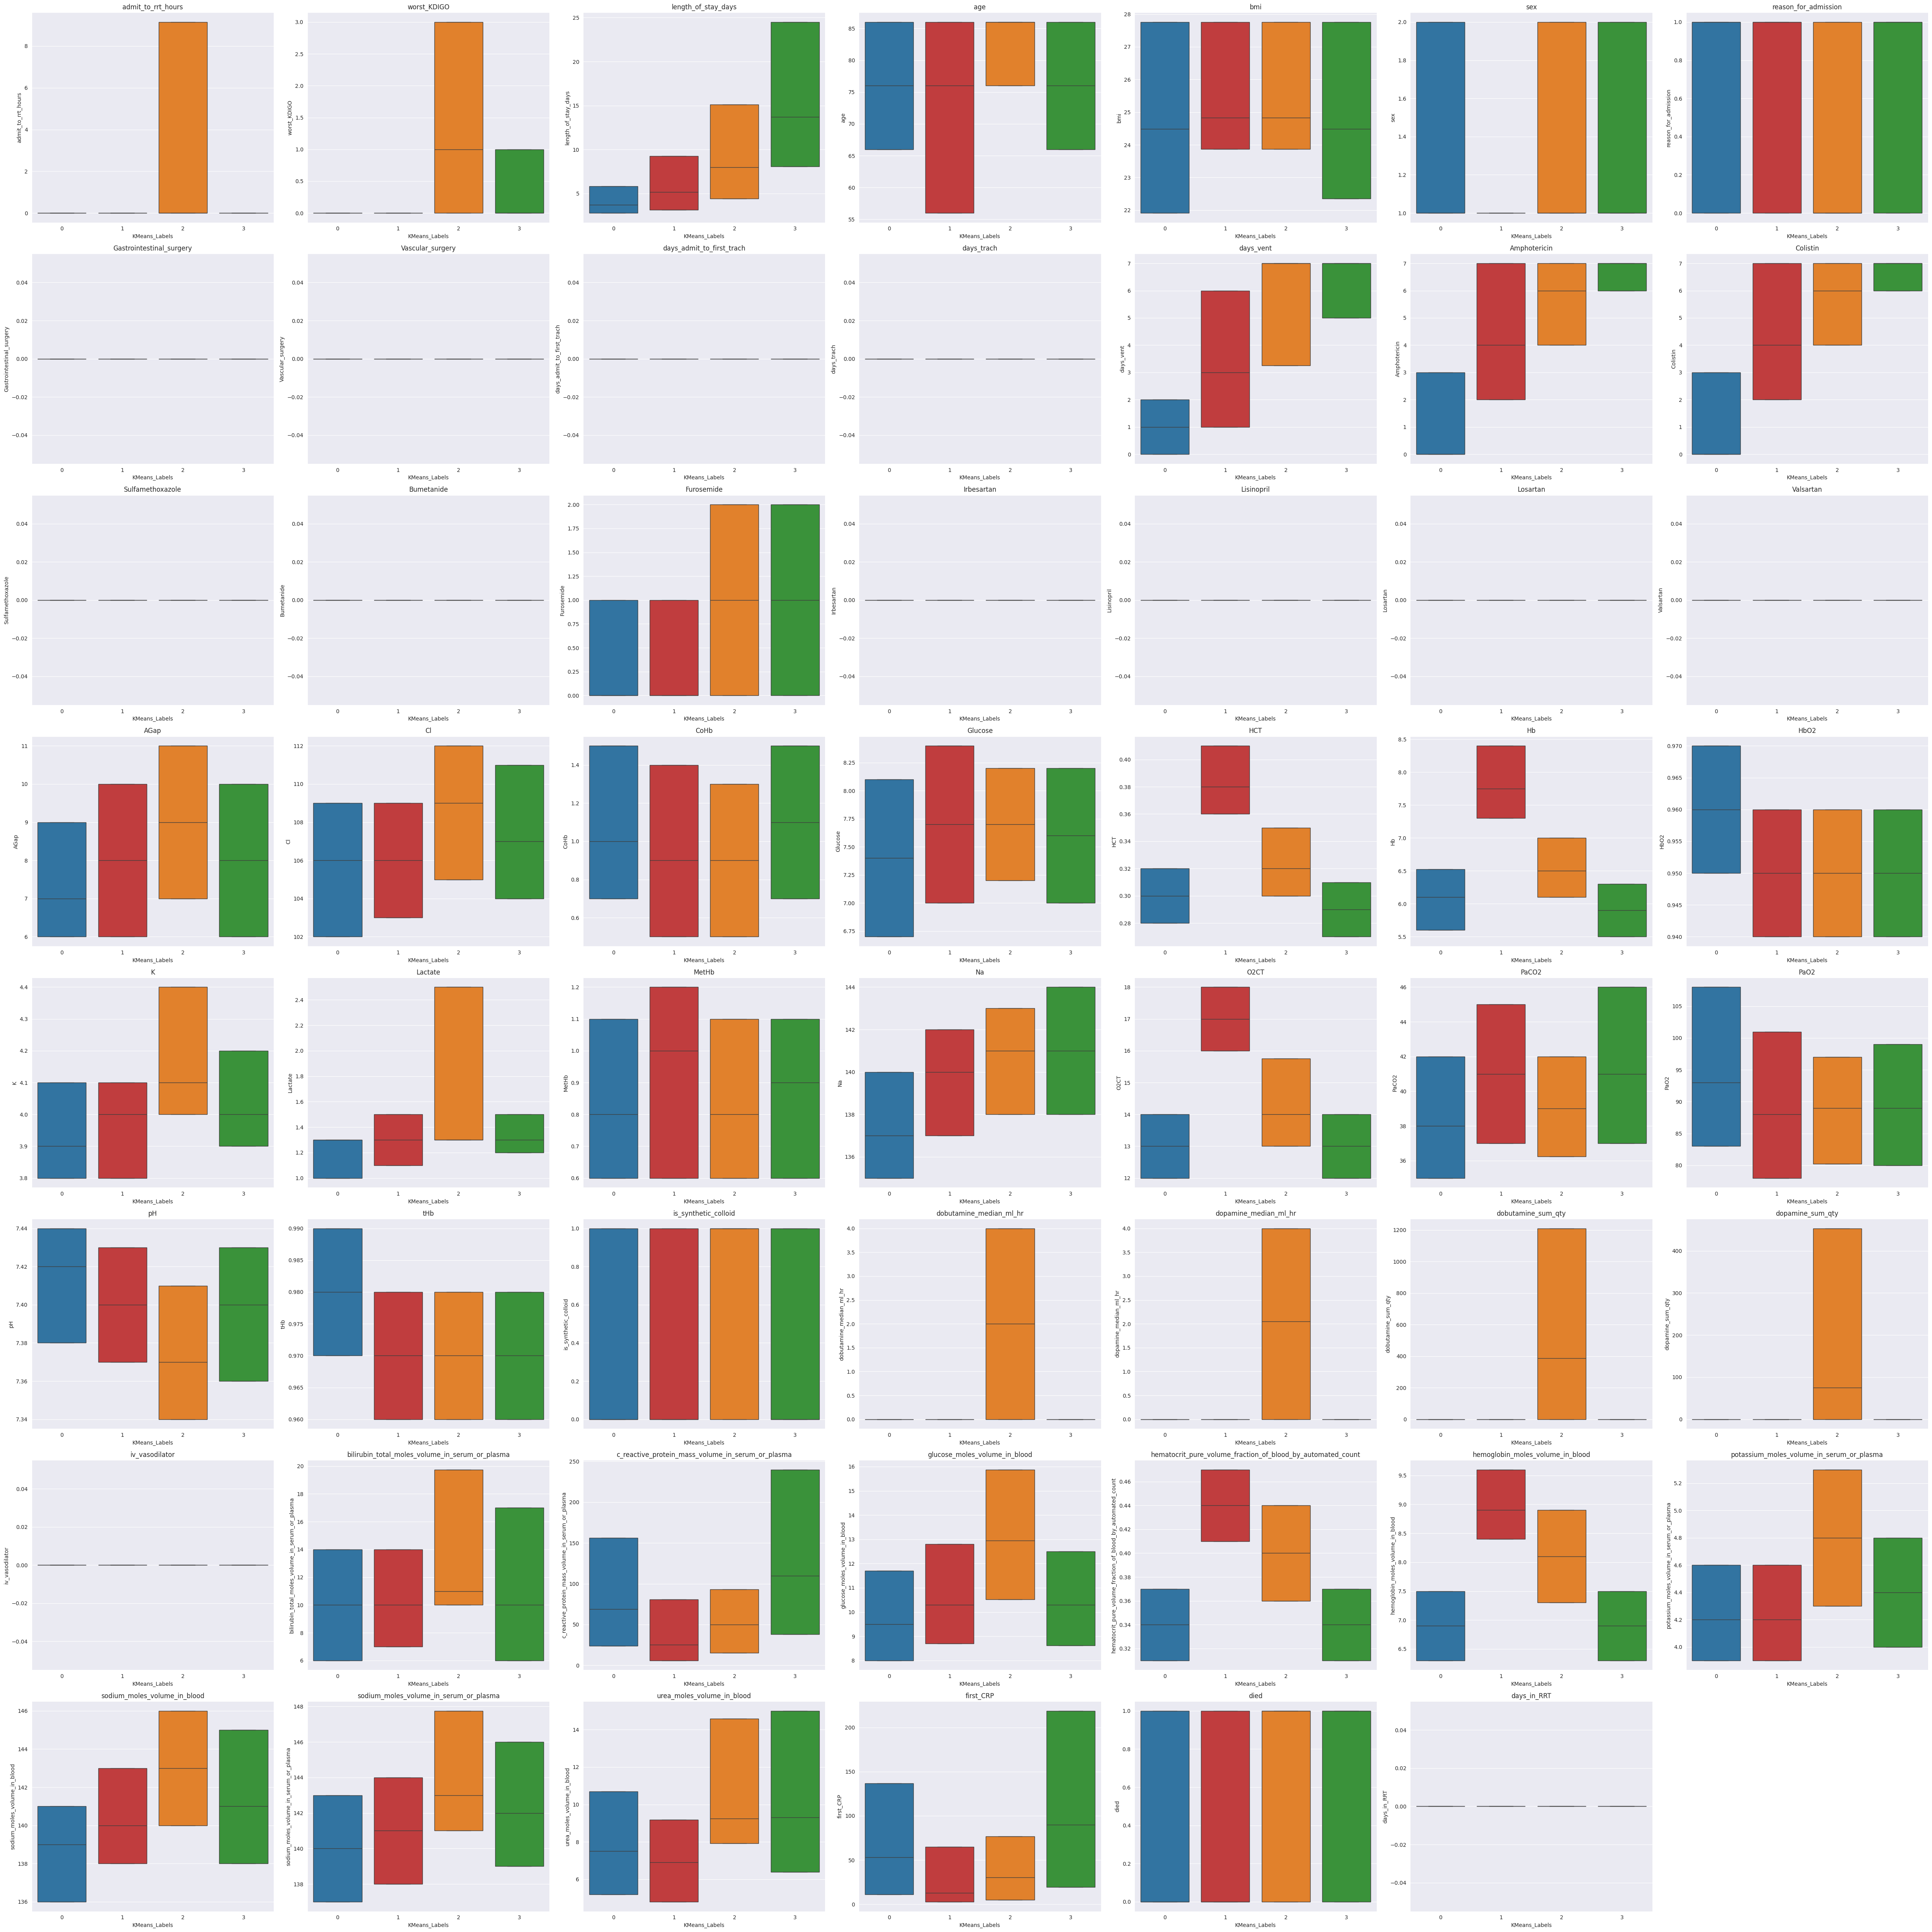

In [196]:
palette ={1: "C3", 2: "C1", 3: "C2", 0: "C0"}

plt.figure(figsize = (50, 50))

for i, variable in enumerate(cols):
    plt.subplot(8, 7, i + 1)
    sns.boxplot(y=data_new[variable], x=data_new['KMeans_Labels'], hue=data_new['KMeans_Labels'], palette = palette
                , showfliers=False, whis=0)
    plt.legend([], [], frameon=False)
    plt.tight_layout()
    plt.title(variable)

plt.show()
